In [ ]:
import argparse
import logging
import os
import pprint
import threading
import time
import timeit
import traceback
import typing

os.environ["OMP_NUM_THREADS"] = "1"  # Necessary for multithreading.

import torch
from torch import multiprocessing as mp
from torch.multiprocessing import Process, Manager
from torch import nn
from torch.nn import functional as F

from torchbeast.core.environment import Environment, Vec_Environment
from torchbeast.atari_wrappers import SokobanWrapper
from torchbeast.base import BaseNet
from torchbeast.train import create_env

import gym
import gym_sokoban
import numpy as np
import math
import logging
from matplotlib import pyplot as plt
from collections import deque

logging.basicConfig(format='%(message)s', level=logging.DEBUG)
logging.getLogger('matplotlib.font_manager').disabled = True

torch.multiprocessing.set_sharing_strategy('file_system')

def get_param(net, name=None):
    keys = []
    for (k, v) in actor_wrapper.model.named_parameters(): 
        if name is None:
            print(k)
        else:
            if name == k: return v
        keys.append(k)
    return keys        


<font size="5">Testing planning algo. for perfect model with bootstrapped values</font>

In [32]:
# Synchronous version of testing 

def n_step_greedy(env, net, model, n, temp):  
    with torch.no_grad():
      if isinstance(env, Vec_Environment):
          num_actions = env.gym_env.action_space[0].n
          bsz = len(env.gym_env.envs)
      else:
          num_actions = env.gym_env.action_space.n
          bsz = 1

      q_ret = torch.zeros(bsz, num_actions).to(device)      
      state = env.clone_state()

      for act in range(num_actions):
          obs = env.step(torch.Tensor(np.full(bsz, act)).long())      
          obs = {k:v.to(device) for k, v in obs.items()}   

          if n > 1:
              action, prob, sub_q_ret = n_step_greedy(env, net, model, n-1, temp)
              ret = obs['reward'] + flags.discounting * torch.max(sub_q_ret, dim=1)[0] * (~obs['done']).float()
          else:
              if model is not None:
                _, baseline, _, _ = model(obs['frame'][0], obs['last_action'], one_hot=False)
                baseline = baseline[-1]
              else:
                baseline = net(obs)[0]['baseline'] 

              ret = obs['reward'] + flags.discounting * baseline * (~obs['done']).float()

          q_ret[:, act] = ret
          env.restore_state(state)

      prob = F.softmax(temp*q_ret, dim=1)
      action = torch.multinomial(prob, num_samples=1)[:, 0]
    
    return action, prob, q_ret  
  
def test_n_step(env, net, model, n, temp=10., eps_n=500):
    print("Testing %d step planning" % n)

    returns = []
    obs = env.initial()
    eps_n_cur = 5

    while(len(returns) <= eps_n):
        obs = {k:v.to(device) for k, v in obs.items()}
        net_out, core_state = net(obs)            
        if n == 0:
            action = net_out["action"][0]
        else:
            action, _, _ = n_step_greedy(env, net, model, n, temp)        
        obs = env.step(action)
        if torch.any(obs['done']):
            returns.extend(obs['episode_return'][obs['done']].numpy())
        if eps_n_cur <= len(returns) and len(returns) > 0: 
            eps_n_cur = len(returns) + 100
            print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
                np.average(returns), np.std(returns) / np.sqrt(len(returns))))
    returns = returns[:eps_n]
    print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
                np.average(returns), np.std(returns) / np.sqrt(len(returns))))
    return returns

bsz = 16
eps_n = 500
temp = 20
use_model = True
device = torch.device("cuda")

# create environments

env = gym.vector.SyncVectorEnv([lambda: SokobanWrapper(gym.make("Sokoban-v0"), noop=True)] * bsz)
env = Vec_Environment(env, bsz)
num_actions = env.gym_env.action_space[0].n
#env = Environment(SokobanWrapper(gym.make("Sokoban-v0"), noop=True))

# import the net

parser = argparse.ArgumentParser()
flags = parser.parse_args("".split())   
flags.discounting = 0.97

net = BaseNet(observation_shape=(3,80,80), num_actions=num_actions, flags=flags)  
net = net.to(device)
checkpoint = torch.load("../models/base_1.tar", map_location="cuda")
net.load_state_dict(checkpoint["model_state_dict"]) 

# initialize net

core_state = net.initial_state(batch_size=bsz)
core_state = tuple(v.to(device) for v in core_state)
net.train(False)

# initialize model

if use_model:  
  flags.model_type_nn = 0
  obs_shape, num_actions = env.gym_env.observation_space.shape, num_actions
  model = Model(flags, obs_shape[1:], num_actions=num_actions).to(device=device)
  checkpoint = torch.load("../models/model_1.tar")
  model.load_state_dict(checkpoint["model_state_dict"])  
  model.train(False)
else:
  model = None

all_returns = {}
#for n in range(1,5):
for n in [1, 2, 5]:
    t = time.process_time()
    all_returns[n] = test_n_step(env, net, model, n, temp, eps_n)
    print("Time required for %d step planning: %f" %(n, time.process_time()-t))

model size:  1095814
Testing 1 step planning
Finish 10 episode: avg. return: 1.62 (+-1.31) 
Finish 110 episode: avg. return: 1.25 (+-0.21) 
Finish 210 episode: avg. return: 1.20 (+-0.16) 
Finish 310 episode: avg. return: 1.11 (+-0.12) 
Finish 410 episode: avg. return: 1.10 (+-0.10) 
Finish 500 episode: avg. return: 1.10 (+-0.09) 
Time required for 1 step planning: 106.269810
Testing 2 step planning
Finish 5 episode: avg. return: 2.89 (+-2.30) 
Finish 107 episode: avg. return: 1.67 (+-0.27) 
Finish 207 episode: avg. return: 1.90 (+-0.23) 
Finish 307 episode: avg. return: 1.82 (+-0.17) 
Finish 407 episode: avg. return: 1.74 (+-0.15) 
Finish 500 episode: avg. return: 1.81 (+-0.14) 
Time required for 2 step planning: 526.741200
Testing 5 step planning
Finish 6 episode: avg. return: 3.52 (+-1.71) 
Finish 106 episode: avg. return: 2.77 (+-0.38) 
Finish 206 episode: avg. return: 2.95 (+-0.29) 
Finish 306 episode: avg. return: 3.01 (+-0.24) 
Finish 406 episode: avg. return: 3.42 (+-0.23) 
Fini

In [ ]:
# Asynchronous version of testing 

def act_m(
    flags,
    actor_index: int,
    net: torch.nn.Module,
    returns: Manager().list,
    eps_n: int,
    n: int,
    temp: float,
):    
    try:    
        #logging.info("Actor %i started", actor_index)
        gym_env = create_env(flags)
        seed = actor_index ^ int.from_bytes(os.urandom(4), byteorder="little")
        gym_env.seed(seed)
        env = Environment(gym_env)
        env_output = env.initial()  
        agent_state = net.initial_state(batch_size=1)
        net_out, unused_state = net(env_output, agent_state)      
        while True:            
            if len(returns) >= eps_n: break
            with torch.no_grad():
                net_out, agent_state = net(env_output, agent_state)                            
            if n == 0:
                action = net_out["action"]
            else:
                action, _, _ = n_step_greedy(env, net, n, temp)            
            env_output = env.step(action)           
            if env_output['done']: returns.append(ret)
            ret = env_output['episode_return'].item()        
        #logging.info("Actor %i end", actor_index)
    except KeyboardInterrupt:
        pass  # Return silently.
    except Exception as e:
        logging.error("Exception in worker process %i", actor_index)
        traceback.print_exc()
        raise e

def asy_test_n_step(n, net, flags, temp):
    
    print("Testing %d step planning" % n)

    mp.set_sharing_strategy('file_system')
    net.share_memory()
    ctx = mp.get_context()        
    returns = Manager().list()

    actor_processes = []
    for i in range(flags.num_actors):
        actor = ctx.Process(target=act_m, args=(flags, i, net, returns, eps_n, n, temp),)
        actor.start()
        actor_processes.append(actor)    

    for actor in actor_processes:
        actor.join()    

    print("Finish %d episode: avg. return: %.2f (+-%.2f)" % (len(returns),
                    np.average(returns), np.std(returns) / np.sqrt(len(returns)),))        
    return returns        
        
parser = argparse.ArgumentParser()
flags = parser.parse_args("".split())   

flags.env = "Sokoban-v0"
flags.env_disable_noop = False
flags.discounting = 0.97     
flags.num_actors = 32
bsz = 1
eps_n = 500
temp = 20
device = torch.device("cpu")

net = BaseNet(observation_shape=(3,80,80), num_actions=5, flags=flags)  
net = net.to("cpu")
checkpoint = torch.load("/home/schk/RS/thinker/models/base_1.tar", map_location="cpu")
net.load_state_dict(checkpoint["model_state_dict"]) 

all_returns = {}
for n in range(4):
    t = time.time()
    all_returns[n] = asy_test_n_step(n, net, flags, temp)
    print("Time required for %d step planning: %f" %(n, time.time()-t))

Results (base_1.tar):
    
Testing 0 step planning <br>
Finish 512 episode: avg. return: 0.12 (+-0.06) <br>
Testing 1 step planning <br>
Finish 502 episode: avg. return: 0.61 (+-0.04) <br>
Testing 2 step planning <br>
Finish 501 episode: avg. return: 0.92 (+-0.04) <br>
Testing 3 step planning <br>
Finish 501 episode: avg. return: 1.01 (+-0.04) <br>

Results (base_2.tar):
Testing 0 step planning <br>
Finish 500 episode: avg. return: 0.27 (+-0.04) <br>
Time required for 0 step planning: 12.629324 <br>
Testing 1 step planning <br>
Finish 502 episode: avg. return: 0.51 (+-0.04) <br>
Time required for 1 step planning: 74.194364 <br>
Testing 2 step planning <br>
Finish 500 episode: avg. return: 0.74 (+-0.04) <br>
Time required for 2 step planning: 339.732901 <br>
Testing 3 step planning <br>
Finish 500 episode: avg. return: 0.76 (+-0.04) <br>
Time required for 3 step planning: 1695.472523 <br>

<font size="5">Model Training Phase</font>

In [156]:
# Generating data for learning model [RUN]

Buffers = typing.Dict[str, typing.List[torch.Tensor]]

def create_buffers_m(flags, obs_shape, num_actions) -> Buffers:
    
    seq_len = flags.seq_len
    seq_n = flags.seq_n
    specs = dict(
        frame=dict(size=(seq_len + 1, *obs_shape), dtype=torch.uint8),
        reward=dict(size=(seq_len + 1,), dtype=torch.float32),
        done=dict(size=(seq_len + 1,), dtype=torch.bool),
        truncated_done=dict(size=(seq_len + 1,), dtype=torch.bool),
        episode_return=dict(size=(seq_len + 1,), dtype=torch.float32),
        episode_step=dict(size=(seq_len + 1,), dtype=torch.int32),
        policy_logits=dict(size=(seq_len + 1, num_actions), dtype=torch.float32),
        baseline=dict(size=(seq_len + 1,), dtype=torch.float32),
        last_action=dict(size=(seq_len + 1,), dtype=torch.int64),
        action=dict(size=(seq_len + 1,), dtype=torch.int64),
        reg_loss=dict(size=(seq_len + 1,), dtype=torch.float32)
    )
    buffers: Buffers = {key: [] for key in specs}
    for _ in range(seq_n):
        for key in buffers:
            buffers[key].append(torch.empty(**specs[key]).share_memory_())
            
    return buffers

def gen_data(
    flags,
    actor_index: int,
    net: torch.nn.Module,
    buffers: Buffers,
    free_queue: mp.SimpleQueue,
):    
    try:    
        #logging.info("Actor %i started", actor_index)
        gym_env = create_env(flags)
        seed = actor_index ^ int.from_bytes(os.urandom(4), byteorder="little")
        gym_env.seed(seed)
        env = Environment(gym_env)
        env_output = env.initial()  
        agent_state = net.initial_state(batch_size=1)
        agent_output, unused_state = net(env_output, agent_state)     
        
        while True:
            index = free_queue.get()
            if index is None:
                break         

            # Write old rollout end.
            for key in env_output:
                buffers[key][index][0, ...] = env_output[key]
            for key in agent_output:
                buffers[key][index][0, ...] = agent_output[key]

            # Do new rollout.
            for t in range(flags.seq_len):
                with torch.no_grad():
                    agent_output, agent_state = net(env_output, agent_state)
                env_output = env.step(agent_output["action"])
                for key in env_output:
                    buffers[key][index][t + 1, ...] = env_output[key]
                for key in agent_output:
                    buffers[key][index][t + 1, ...] = agent_output[key]
                    
    except KeyboardInterrupt:
        pass  # Return silently.
    except Exception as e:
        logging.error("Exception in worker process %i", actor_index)
        traceback.print_exc()
        raise e
        

# Models

DOWNSCALE_C = 2

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=dilation,
        groups=groups, bias=False, dilation=dilation,)

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class ResBlock(nn.Module):
    expansion: int = 1

    def __init__(self, inplanes, outplanes=None):
        super().__init__()
        if outplanes is None: outplanes = inplanes 
        norm_layer = nn.BatchNorm2d
        self.conv1 = conv3x3(inplanes, inplanes)
        self.bn1 = norm_layer(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(inplanes, outplanes)
        self.bn2 = norm_layer(outplanes)
        self.skip_conv = (outplanes != inplanes)
        if outplanes != inplanes:
            self.conv3 = conv1x1(inplanes, outplanes)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.skip_conv:
            out += self.conv3(identity)
        else:
            out += identity
        out = self.relu(out)
        return out
    
class FrameEncoder(nn.Module):    
    def __init__(self, num_actions, frame_channels=3, type_nn=0):
        self.num_actions = num_actions
        super(FrameEncoder, self).__init__() 
        
        if type_nn == 0:
            n_block = 1
        elif type_nn == 1:
            n_block = 2
        
        self.conv1 = nn.Conv2d(in_channels=frame_channels+num_actions, out_channels=128//DOWNSCALE_C, kernel_size=3, stride=2, padding=1) 
        res = nn.ModuleList([ResBlock(inplanes=128//DOWNSCALE_C) for i in range(n_block)]) # Deep: 2 blocks here
        self.res1 = torch.nn.Sequential(*res)
        self.conv2 = nn.Conv2d(in_channels=128//DOWNSCALE_C, out_channels=256//DOWNSCALE_C, 
                               kernel_size=3, stride=2, padding=1) 
        res = nn.ModuleList([ResBlock(inplanes=256//DOWNSCALE_C) for i in range(n_block)]) # Deep: 3 blocks here
        self.res2 = torch.nn.Sequential(*res)
        self.avg1 = nn.AvgPool2d(3, stride=2, padding=1)
        res = nn.ModuleList([ResBlock(inplanes=256//DOWNSCALE_C) for i in range(n_block)]) # Deep: 3 blocks here
        self.res3 = torch.nn.Sequential(*res)
        self.avg2 = nn.AvgPool2d(3, stride=2, padding=1)
    
    def forward(self, x, actions):        
        # input shape: B, C, H, W        
        # action shape: B 
        
        x = x.float() / 255.0    
        actions = actions.unsqueeze(-1).unsqueeze(-1).tile([1, 1, x.shape[2], x.shape[3]])        
        x = torch.concat([x, actions], dim=1)
        x = F.relu(self.conv1(x))
        x = self.res1(x)
        x = F.relu(self.conv2(x))
        x = self.res2(x)
        x = self.avg1(x)
        x = self.res3(x)
        x = self.avg2(x)
        return x
    
class DynamicModel(nn.Module):
    def __init__(self, num_actions, inplanes=256, type_nn=0):        
        super(DynamicModel, self).__init__()
        self.type_nn = type_nn
        if type_nn == 0:
            res = nn.ModuleList([ResBlock(inplanes=inplanes+num_actions, outplanes=inplanes)] + [
                    ResBlock(inplanes=inplanes) for i in range(4)]) 
        elif type_nn == 1:                      
            res = nn.ModuleList([ResBlock(inplanes=inplanes) for i in range(15)] + [
                    ResBlock(inplanes=inplanes, outplanes=inplanes*num_actions)])

        
        self.res = torch.nn.Sequential(*res)
        self.num_actions = num_actions
    
    def forward(self, x, actions):              
        bsz, c, h, w = x.shape
        if self.training:
            x.register_hook(lambda grad: grad * 0.5)
        if self.type_nn == 0:
            actions = actions.unsqueeze(-1).unsqueeze(-1).tile([1, 1, x.shape[2], x.shape[3]])        
            x = torch.concat([x, actions], dim=1)
            out = self.res(x)
        elif self.type_nn == 1:            
            res_out = self.res(x).view(bsz, self.num_actions, c, h, w)        
            actions = actions.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            out = torch.sum(actions * res_out, dim=1)
        return out
    
class Output_rvpi(nn.Module):   
    def __init__(self, num_actions, input_shape):         
        super(Output_rvpi, self).__init__()        
        c, h, w = input_shape
        self.conv1 = nn.Conv2d(in_channels=c, out_channels=c//2, kernel_size=3, padding='same') 
        self.conv2 = nn.Conv2d(in_channels=c//2, out_channels=c//4, kernel_size=3, padding='same') 
        fc_in = h * w * (c // 4)
        self.fc_r = nn.Linear(fc_in, 1) 
        self.fc_v = nn.Linear(fc_in, 1) 
        self.fc_logits = nn.Linear(fc_in, num_actions)         
        
    def forward(self, x):    
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, start_dim=1)
        r, v, logits = self.fc_r(x), self.fc_v(x), self.fc_logits(x)
        return r, v, logits

class Model(nn.Module):    
    def __init__(self, flags, obs_shape, num_actions):        
        super(Model, self).__init__()      
        self.flags = flags
        self.obs_shape = obs_shape
        self.num_actions = num_actions          
        self.type_nn = flags.model_type_nn # type_nn: type of neural network for the model; 0 for small, 1 for large
        self.frameEncoder = FrameEncoder(num_actions=num_actions, frame_channels=obs_shape[0], type_nn=self.type_nn)
        self.dynamicModel = DynamicModel(num_actions=num_actions, inplanes=256//DOWNSCALE_C, type_nn=self.type_nn)
        self.output_rvpi = Output_rvpi(num_actions=num_actions, input_shape=(256//DOWNSCALE_C, 
                      obs_shape[1]//16, obs_shape[1]//16))
        
    def forward(self, x, actions, one_hot=False):
        # Input
        # x: frames with shape (B, C, H, W), in the form of s_t
        # actions: action (int64) with shape (k+1, B), in the form of a_{t-1}, a_{t}, a_{t+1}, .. a_{t+k-1}
        # Output
        # reward: predicted reward with shape (k, B), in the form of r_{t+1}, r_{t+2}, ..., r_{t+k}
        # value: predicted value with shape (k+1, B), in the form of v_{t}, v_{t+1}, v_{t+2}, ..., v_{t+k}
        # policy: predicted policy with shape (k+1, B), in the form of pi_{t}, pi_{t+1}, pi_{t+2}, ..., pi_{t+k}
        # encoded: encoded states with shape (k+1, B), in the form of z_t, z_{t+1}, z_{t+2}, ..., z_{t+k}
        # Recall the transition notation: s_t, a_t, r_{t+1}, s_{t+1}, ...
        
        if not one_hot:
            actions = F.one_hot(actions, self.num_actions)                
        encoded = self.frameEncoder(x, actions[0])
        return self.forward_encoded(encoded, actions[1:], one_hot=True)
    
    def forward_encoded(self, encoded, actions, one_hot=False):
        if not one_hot:
            actions = F.one_hot(actions, self.num_actions)                
        
        r, v, logits = self.output_rvpi(encoded)
        r_list, v_list, logits_list = [], [v.squeeze(-1).unsqueeze(0)], [logits.unsqueeze(0)]
        encoded_list = [encoded.unsqueeze(0)]
        
        for k in range(actions.shape[0]):            
            encoded = self.dynamicModel(encoded, actions[k])
            r, v, logits = self.output_rvpi(encoded)
            r_list.append(r.squeeze(-1).unsqueeze(0))
            v_list.append(v.squeeze(-1).unsqueeze(0))
            logits_list.append(logits.unsqueeze(0))
            encoded_list.append(encoded.unsqueeze(0))        
        
        if len(r_list) > 0:
            rs = torch.concat(r_list, dim=0)
        else:
            rs = None
            
        vs = torch.concat(v_list, dim=0)
        logits = torch.concat(logits_list, dim=0)
        encodeds = torch.concat(encoded_list, dim=0)        
        
        return rs, vs, logits, encodeds

#model = Model(flags, (3, 80, 80), num_actions=5)
#rs, vs, logits = model(torch.rand(16, 3, 80, 80), torch.ones(8, 16).long())

# functions for training models

def get_batch_m(flags, buffers: Buffers):
    batch_indices = np.random.randint(flags.seq_n, size=flags.bsz)
    time_indices = np.random.randint(flags.seq_len - flags.unroll_len, size=flags.bsz)
    batch = {key: torch.stack([buffers[key][m][time_indices[n]:time_indices[n]+flags.unroll_len+1] 
                          for n, m in enumerate(batch_indices)], dim=1) for key in buffers}
    batch = {k: t.to(device=flags.device, non_blocking=True) for k, t in batch.items()}
    return batch

def compute_cross_entropy_loss(logits, target_logits, mask):
    target_policy = F.softmax(target_logits, dim=-1)
    log_policy = F.log_softmax(logits, dim=-1)
    return -torch.sum(target_policy * log_policy * (~mask).float().unsqueeze(-1))

def compute_loss_m(model, batch):
    rs, vs, logits, _ = model(batch['frame'][0], batch['action'])
    logits = logits[:-1]

    target_rewards = batch['reward'][1:]
    target_logits = batch['policy_logits'][1:]

    target_vs = []
    target_v = model(batch['frame'][-1], batch['action'][[-1]])[1][0].detach()
    
    for t in range(vs.shape[0]-1, 0, -1):
        new_target_v = batch['reward'][t] + flags.discounting * (target_v * (~batch['done'][t]).float())# +
                           #vs[t-1] * (batch['truncated_done'][t]).float())
        target_vs.append(new_target_v.unsqueeze(0))
        target_v = new_target_v
    target_vs.reverse()
    target_vs = torch.concat(target_vs, dim=0)

    # if done on step j, r_{j}, v_{j-1}, a_{j-1} has the last valid loss 
    # rs is stored in the form of r_{t+1}, ..., r_{t+k}
    # vs is stored in the form of v_{t}, ..., v_{t+k-1}
    # logits is stored in the form of a{t}, ..., a_{t+k-1}

    done_masks = []
    done = torch.zeros(vs.shape[1]).bool().to(batch['done'].device)
    for t in range(vs.shape[0]):
        if t > 0: done = torch.logical_or(done, batch['done'][t])
        done_masks.append(done.unsqueeze(0))

    done_masks = torch.concat(done_masks[:-1], dim=0)
    
    # compute final loss
    huberloss = torch.nn.HuberLoss(reduction='none', delta=1.0)    
    #rs_loss = torch.sum(huberloss(rs, target_rewards.detach()) * (~done_masks).float())
    rs_loss = torch.sum(((rs - target_rewards) ** 2) * (~done_masks).float())
    #vs_loss = torch.sum(huberloss(vs[:-1], target_vs.detach()) * (~done_masks).float())
    vs_loss = torch.sum(((vs[:-1] - target_vs) ** 2) * (~done_masks).float())
    logits_loss = compute_cross_entropy_loss(logits, target_logits.detach(), done_masks)
    
    return rs_loss, vs_loss, logits_loss

# n-step exhaustive search

def n_step_greedy_model(state, action, model, n, encoded=None, temp=20.): 
    
    # Either input state, action (S_t, A_{t-1}) or the encoded Z_t
    # state / encoded in the shape of (B, C, H, W)
    # action in the shape of (B)    
    with torch.no_grad():    
      bsz = state.shape[0] if encoded is None else encoded.shape[0]
      device = state.device if encoded is None else encoded.device
      num_actions = model.num_actions    

      q_ret = torch.zeros(bsz, num_actions).to(device)        

      for act in range(num_actions):        
          new_action = torch.Tensor(np.full(bsz, act)).long().to(device)    
          if encoded is None:            
              old_new_actions = torch.concat([action.unsqueeze(0), new_action.unsqueeze(0)], dim=0)
              rs, vs, logits, encodeds = model(state, old_new_actions)
          else:
              rs, vs, logits, encodeds = model.forward_encoded(encoded, new_action.unsqueeze(0))

          if n > 1:
              action, prob, sub_q_ret = n_step_greedy_model(state=None, action=None, 
                         model=model, n=n-1, encoded=encodeds[1])
              ret = rs[0] + flags.discounting * torch.max(sub_q_ret, dim=1)[0] 
              #ret = rs[0] + flags.discounting * torch.mean(sub_q_ret, dim=1)
          else:
              ret = rs[0] + flags.discounting * vs[1]
          q_ret[:, act] = ret

      prob = F.softmax(temp*q_ret, dim=1)
      action = torch.multinomial(prob, num_samples=1)[:, 0]
    
    return action, prob, q_ret        
   
# d-step n-rollout search   
    
def n_d_uniform_rollout(state, action, model, n, d, temp, env=None):

    # state in the shape of (B, C, H, W)
    # action in the shape of (B)    
    # n: number of rollout
    # d: depth of rollout
    # temp: temperature 
    # env: if not None, then the transition function will use the true transition
    
    with torch.no_grad():    
        bsz = state.shape[0]
        device = state.device 
        num_actions = model.num_actions    
        rollout_ret = torch.zeros(bsz, n).to(device)      
        initial_action = torch.zeros(bsz, n, dtype=torch.long).to(device)      
        if env is not None: state = env.clone_state()        
        for rollout_n in range(n):            
            new_action = torch.multinomial(torch.tensor(np.full((bsz, num_actions), 1/num_actions)), num_samples=1)  
            new_action = new_action[:,0].to(device)  
            initial_action[:, rollout_n] = new_action
            if env is None:              
              old_new_actions = torch.concat([action.unsqueeze(0), new_action.unsqueeze(0)], dim=0)
              rs, vs, logits, encodeds = model(state, old_new_actions, one_hot=False)
              encoded = encodeds[-1]
              ret = rs[0]
            else:              
              obs = env.step(new_action)
              ret = obs['reward'].to(device)
              done = obs['done'].to(device)
              
            c_discount = flags.discounting
            for rollout_d in range(d - 1):            
                new_action = torch.multinomial(torch.tensor(np.full((bsz, num_actions), 1/num_actions)), num_samples=1)  
                new_action = new_action[:,0].to(device) 
                if env is None:
                  rs, vs, logits, encodeds = model.forward_encoded(encoded, new_action.unsqueeze(0), one_hot=False)
                  encoded = encodeds[-1]
                  reward = rs[0]
                else:
                  obs = env.step(new_action)
                  reward = obs['reward'].to(device) * (1 - done.float())
                  done = torch.logical_or(done, obs['done'].to(device))                  
                ret = ret + c_discount * reward
                c_discount = c_discount * flags.discounting
                
            if env is None:
              v = vs[-1]
            else:
              _, vs, _, _ = model(obs['frame'][0].to(device), obs['last_action'].to(device), 
                        one_hot=False) 
              v = vs[-1] * (1 - done.float())              
            ret = ret + c_discount * v
            rollout_ret[:, rollout_n] = ret
            if env is not None: env.restore_state(state)
        prob = torch.softmax(temp*rollout_ret, dim=-1)
        sel = torch.multinomial(prob, num_samples=1)[:,0]  
        action = initial_action[np.arange(bsz), sel]
    return action  
  

# MCTS testing

class MCTS:
    """
    Core Monte Carlo Tree Search algorithm.
    To decide on an action, we run N simulations, always starting at the root of
    the search tree and traversing the tree according to the UCB formula until we
    reach a leaf node.
    """
    def __init__(self, flags, num_actions):
        self.flags = flags
        self.num_actions = num_actions

    def run(self, obs, model, add_exploration_noise, env, root=None, min_max_stats=None):
        """
        At the root of the search tree we use the representation function to obtain a
        hidden state given the current observation.
        We then run a Monte Carlo Tree Search using only action sequences and the model
        learned by the network.
        Only supports a batch size of 1.        
        """
        with torch.no_grad():
            if env is not None: initial_state = env.clone_state()   
            if (root is not None and not root.hidden_state['done'] and 
                root.children[obs["last_action"].item()].expanded):
              root = root.children[obs["last_action"].item()]
              root_predicted_value = 0.
              root.hidden_state
            else:  
              root = Node(0)
              _, root_predicted_value, policy_logits, hidden_state = model(
                  obs["frame"][0], obs["last_action"], one_hot=False)
              reward = 0.            

              root_predicted_value = root_predicted_value[-1].item()
              policy_logits = policy_logits[-1]
              if env is None:
                hidden_state = hidden_state[-1]  
              else:
                hidden_state = initial_state            
                hidden_state['done'] = False

              root.expand(num_actions, reward, policy_logits, hidden_state,)

            if add_exploration_noise:
                root.add_exploration_noise(
                    dirichlet_alpha=self.flags.root_dirichlet_alpha,
                    exploration_fraction=self.flags.root_exploration_fraction,
                )
                
            if min_max_stats is None:
              min_max_stats = MinMaxStats()
            max_tree_depth = 0
            device = obs["frame"].device
            
            #print("p at root:", torch.softmax(policy_logits, dim=-1))
            steps = 0
            for k in range(self.flags.num_simulations): 
                
                #print("=======%d iteration======"%k)
                node = root
                search_path = [node]
                current_tree_depth = 0                    

                while node.expanded():
                    current_tree_depth += 1                    
                    steps += 1
                    action, node = self.select_child(node, min_max_stats)                    
                    search_path.append(node)
                    #print("action sel: %d" % action)
                
                #np.set_printoptions(precision=5)
                #for x in ["prior_score", "value_score", "pb_c", "prior", "visit_count"]:                    
                #    print(x, "\t", np.array([getattr(search_path[0].children[n], x) for n in range(5)]))

                # Inside the search tree we use the dynamics function to obtain the next hidden
                # state given an action and the previous hidden state
                parent = search_path[-2]     
                
                if env is None:
                  reward, value, policy_logits, hidden_state = model.forward_encoded(
                    parent.hidden_state, torch.tensor([[action]]).to(parent.hidden_state.device), one_hot=False)
                  reward = reward[-1].item()
                  value = value[-1].item()
                  policy_logits = policy_logits[-1]
                  policy_values = None
                  hidden_state = hidden_state[-1]
                else:
                  if not parent.hidden_state['done']:
                    env.restore_state(parent.hidden_state)
                    obs = env.step(torch.tensor([action]).long())
                    obs = {k:v.to(device) for k, v in obs.items()}
                    _, value, policy_logits, _ =  model(obs["frame"][0], obs["last_action"], one_hot=False)
                    reward = obs['reward'].item()
                    value = (value[-1] * (1 - obs['done'].float())).item()
                    policy_logits = policy_logits[-1]
                    policy_values = None
                    hidden_state = env.clone_state()
                    hidden_state['done'] = obs['done'].item()
                  else:
                    reward = 0.
                    value = 0.
                    policy_logits = None
                    policy_values ={k:v.prior for k, v in parent.children.items()}
                    hidden_state = parent.hidden_state
                #print("model final output: %4f" % value)
                
                node.expand(num_actions, reward, policy_logits, hidden_state, policy_values)
                self.backpropagate(search_path, value, min_max_stats)
                max_tree_depth = max(max_tree_depth, current_tree_depth)

            extra_info = {
                "max_tree_depth": max_tree_depth,
                "root_predicted_value": root_predicted_value,
                "steps": steps
            }
            if env is not None: env.restore_state(initial_state)
        return root, min_max_stats, extra_info

    def select_child(self, node, min_max_stats):
        """
        Select the child with the highest UCB score.
        """
        max_ucb = max(
            self.ucb_score(node, child, min_max_stats)
            for action, child in node.children.items()
        )
        action = np.random.choice(
            [
                action
                for action, child in node.children.items()
                if self.ucb_score(node, child, min_max_stats) == max_ucb
            ]
        )
        return action, node.children[action]

    def ucb_score(self, parent, child, min_max_stats):
        """
        The score for a node is based on its value, plus an exploration bonus based on the prior.
        """
        pb_c = (
            math.log(
                (parent.visit_count + self.flags.pb_c_base + 1) / self.flags.pb_c_base
            )
            + self.flags.pb_c_init
        )
        pb_c *= math.sqrt(parent.visit_count) / (child.visit_count + 1)

        prior_score = pb_c * child.prior

        if child.visit_count > 0:
            # Mean value Q
            value_score = min_max_stats.normalize(
                child.reward + self.flags.discounting * child.value())
        else:
            value_score = 0
            
        child.pb_c = pb_c
        child.prior_score = prior_score
        child.value_score = value_score
        
        return prior_score + value_score

    def backpropagate(self, search_path, value, min_max_stats):
        """
        At the end of a simulation, we propagate the evaluation all the way up the tree
        to the root.
        """
        #print("bs value: %.4f" % value)
        for n, node in enumerate(reversed(search_path)):
            node.value_sum += value
            node.visit_count += 1
            min_max_stats.update(node.reward + self.flags.discounting * node.value())
            value = node.reward + self.flags.discounting * value
            #print("%d - val: %.4f r: %.4f" % (n, value, node.reward))
            #print("node value_sum %.4f" % node.value_sum)

class Node:
    def __init__(self, prior):
        self.visit_count = 0
        self.prior = prior
        self.value_sum = 0
        self.children = {}
        self.hidden_state = None
        self.reward = 0

    def expanded(self):
        return len(self.children) > 0

    def value(self):
        if self.visit_count == 0:
            return 0
        return self.value_sum / self.visit_count

    def expand(self, num_actions, reward, policy_logits, hidden_state, policy_values=None):
        """
        We expand a node using the value, reward and policy prediction obtained from the
        neural network.
        """
        self.reward = reward
        self.hidden_state = hidden_state
        if policy_values is None:
            policy_values = torch.softmax(policy_logits[0], dim=0).tolist()
        for a in range(num_actions):
            self.children[a] = Node(policy_values[a])

    def add_exploration_noise(self, dirichlet_alpha, exploration_fraction):
        """
        At the start of each search, we add dirichlet noise to the prior of the root to
        encourage the search to explore new actions.
        """
        actions = list(self.children.keys())
        noise = np.random.dirichlet([dirichlet_alpha] * len(actions))
        frac = exploration_fraction
        for a, n in zip(actions, noise):
            self.children[a].prior = self.children[a].prior * (1 - frac) + n * frac

class MinMaxStats:
    """
    A class that holds the min-max values of the tree.
    """

    def __init__(self):
        self.maximum = -float("inf")
        self.minimum = float("inf")

    def update(self, value):
        self.maximum = max(self.maximum, value)
        self.minimum = min(self.minimum, value)

    def normalize(self, value):
        if self.maximum > self.minimum:
            # We normalize only when we have set the maximum and minimum values
            return (value - self.minimum) / (self.maximum - self.minimum)
        return value            

def select_action(node, temperature):
    """
    Select action according to the visit count distribution and the temperature.
    The temperature is changed dynamically with the visit_softmax_temperature function
    in the config.
    """
    visit_counts = np.array(
        [child.visit_count for child in node.children.values()], dtype="int32"
    )
    actions = [action for action in node.children.keys()]
    if temperature == 0:
        action = actions[np.argmax(visit_counts)]
    elif temperature == float("inf"):
        action = np.random.choice(actions)
    else:
        # See paper appendix Data Generation
        visit_count_distribution = visit_counts ** (1 / temperature)
        visit_count_distribution = visit_count_distribution / sum(
            visit_count_distribution
        )
        action = np.random.choice(actions, p=visit_count_distribution)
    #print("visit_counts", visit_counts)
    #print("visit_count_distribution", visit_count_distribution)
    return action
  
def test_model(n, model, flags, eps_n=100, temp=20., mode=0, perfect=False, **kwargs):   
    # mode 0 for n-step exhuastive search
    # mode 1 for d-step n-rollout uniform search
    # mode 2 for MCTS
    
    if mode == 2:
      bsz = 1
      env = Environment(SokobanWrapper(gym.make("Sokoban-v0"), noop=True))
      num_actions = env.gym_env.action_space.n      
    else:      
      bsz = 100
      env = gym.vector.SyncVectorEnv([lambda: SokobanWrapper(gym.make("Sokoban-v0"), noop=True)] * bsz)
      env = Vec_Environment(env, bsz)
      num_actions = env.gym_env.action_space[0].n
    
    if mode == 0:
        print("Testing %d-step exhaustive planning" % n) 
    elif mode == 1:
        d = kwargs["d"]
        print("Testing %d-step %d-rollout planning" % (d, n))
    elif mode == 2:
        mcts = MCTS(kwargs["mcts_flags"], num_actions)
        print("Testing MCTS with %d simulations" % kwargs["mcts_flags"].num_simulations)
    else:
        raise Exception("Not implemented")
    
    model.train(False)
    device = torch.device("cuda")
    
    returns = []
    steps = []
    
    obs = env.initial()
    action = torch.zeros(bsz).long().to(device)
    eps_n_cur = 0
    root, min_max_stats = None, None

    while(len(returns) <= eps_n):
        obs = {k:v.to(device) for k, v in obs.items()}
        if mode == 0:
            assert not perfect
            new_action, _, _ = n_step_greedy_model(obs['frame'][0], action, model, n, None, temp)        
        elif mode == 1:
            env_input = env if perfect else None
            new_action = n_d_uniform_rollout(obs['frame'][0], action, model, n, d, temp, env_input)     
        elif mode == 2:
            env_input = env if perfect else None
            root_, min_max_stats_, extra_info = mcts.run(obs, model, True, env_input, root, min_max_stats)                
            if kwargs["mcts_flags"].tcarry:
              root = root_
              min_max_stats = min_max_stats_
            new_action = torch.tensor([select_action(root_, temp)]).long().to(device)
            steps.append(extra_info['steps'])
        obs = env.step(new_action)
        action = new_action
        if torch.any(obs['done']):
            returns.extend(obs['episode_return'][obs['done']].numpy())
            if mode == 2: root, min_max_stats = None, None              
        if eps_n_cur <= len(returns) and len(returns) > 0: 
            eps_n_cur = len(returns) + 1
            pnt_str = "Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),                                                                          
                np.average(returns), np.std(returns) / np.sqrt(len(returns)))
            if mode == 2:
              pnt_str += "steps: %.2f" % np.average(steps[-100:])
            print(pnt_str)  
            
            
    returns = returns[:eps_n]
    print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
                np.average(returns), np.std(returns) / np.sqrt(len(returns))))
    return returns

In [157]:
# MCTS

mcts_returns = {}
parser = argparse.ArgumentParser()
mcts_flags = parser.parse_args([])  
mcts_flags.discounting = 0.97
mcts_flags.pb_c_init = 1.25
mcts_flags.pb_c_base = 19652
mcts_flags.root_dirichlet_alpha = 0.25
mcts_flags.root_exploration_fraction = 0.25
mcts_flags.tcarry = True
for n in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]:
    mcts_flags.num_simulations = n
    mcts_returns[n] = test_model(n, model, flags, eps_n=500, temp=0.5, mode=2, perfect=True, mcts_flags=mcts_flags)

Testing MCTS with 5 simulations
Finish 1 episode: avg. return: 0.84 (+-0.00) steps: 9.56
Finish 2 episode: avg. return: 0.34 (+-0.35) steps: 6.95
Finish 3 episode: avg. return: 0.83 (+-0.46) steps: 21.61
Finish 4 episode: avg. return: 4.03 (+-2.79) steps: 19.34
Finish 5 episode: avg. return: 3.59 (+-2.27) steps: 11.45
Finish 6 episode: avg. return: 3.14 (+-1.94) steps: 17.10
Finish 7 episode: avg. return: 2.81 (+-1.69) steps: 10.92
Finish 8 episode: avg. return: 2.43 (+-1.52) steps: 10.08
Finish 9 episode: avg. return: 2.26 (+-1.36) steps: 11.12
Finish 10 episode: avg. return: 2.11 (+-1.23) steps: 8.68
Finish 11 episode: avg. return: 2.09 (+-1.12) steps: 9.20
Finish 12 episode: avg. return: 1.98 (+-1.03) steps: 11.80
Finish 13 episode: avg. return: 1.97 (+-0.95) steps: 10.53
Finish 14 episode: avg. return: 1.89 (+-0.89) steps: 9.50
Finish 15 episode: avg. return: 1.75 (+-0.84) steps: 8.79
Finish 16 episode: avg. return: 1.69 (+-0.79) steps: 8.15
Finish 17 episode: avg. return: 1.64 (+-

Finish 140 episode: avg. return: 1.68 (+-0.29) steps: 14.23
Finish 141 episode: avg. return: 1.66 (+-0.29) steps: 8.95
Finish 142 episode: avg. return: 1.66 (+-0.29) steps: 8.19
Finish 143 episode: avg. return: 1.65 (+-0.28) steps: 14.27
Finish 144 episode: avg. return: 1.64 (+-0.28) steps: 8.08
Finish 145 episode: avg. return: 1.63 (+-0.28) steps: 11.49
Finish 146 episode: avg. return: 1.63 (+-0.28) steps: 8.74
Finish 147 episode: avg. return: 1.63 (+-0.28) steps: 17.28
Finish 148 episode: avg. return: 1.62 (+-0.27) steps: 7.54
Finish 149 episode: avg. return: 1.61 (+-0.27) steps: 14.79
Finish 150 episode: avg. return: 1.61 (+-0.27) steps: 8.11
Finish 151 episode: avg. return: 1.59 (+-0.27) steps: 7.44
Finish 152 episode: avg. return: 1.59 (+-0.27) steps: 7.16
Finish 153 episode: avg. return: 1.58 (+-0.27) steps: 16.22
Finish 154 episode: avg. return: 1.58 (+-0.26) steps: 13.19
Finish 155 episode: avg. return: 1.57 (+-0.26) steps: 10.39
Finish 156 episode: avg. return: 1.57 (+-0.26) s

Finish 278 episode: avg. return: 1.35 (+-0.18) steps: 13.08
Finish 279 episode: avg. return: 1.35 (+-0.18) steps: 12.87
Finish 280 episode: avg. return: 1.35 (+-0.17) steps: 7.81
Finish 281 episode: avg. return: 1.34 (+-0.17) steps: 10.82
Finish 282 episode: avg. return: 1.33 (+-0.17) steps: 16.22
Finish 283 episode: avg. return: 1.33 (+-0.17) steps: 12.00
Finish 284 episode: avg. return: 1.32 (+-0.17) steps: 12.51
Finish 285 episode: avg. return: 1.32 (+-0.17) steps: 11.99
Finish 286 episode: avg. return: 1.32 (+-0.17) steps: 13.93
Finish 287 episode: avg. return: 1.32 (+-0.17) steps: 10.23
Finish 288 episode: avg. return: 1.32 (+-0.17) steps: 10.78
Finish 289 episode: avg. return: 1.32 (+-0.17) steps: 13.83
Finish 290 episode: avg. return: 1.32 (+-0.17) steps: 10.53
Finish 291 episode: avg. return: 1.32 (+-0.17) steps: 13.87
Finish 292 episode: avg. return: 1.31 (+-0.17) steps: 10.19
Finish 293 episode: avg. return: 1.31 (+-0.17) steps: 7.23
Finish 294 episode: avg. return: 1.31 (+-0

Finish 416 episode: avg. return: 1.07 (+-0.12) steps: 9.25
Finish 417 episode: avg. return: 1.07 (+-0.12) steps: 19.85
Finish 418 episode: avg. return: 1.07 (+-0.12) steps: 10.70
Finish 419 episode: avg. return: 1.06 (+-0.12) steps: 11.42
Finish 420 episode: avg. return: 1.06 (+-0.12) steps: 8.84
Finish 421 episode: avg. return: 1.06 (+-0.12) steps: 20.49
Finish 422 episode: avg. return: 1.06 (+-0.12) steps: 10.28
Finish 423 episode: avg. return: 1.06 (+-0.12) steps: 9.23
Finish 424 episode: avg. return: 1.06 (+-0.12) steps: 18.25
Finish 425 episode: avg. return: 1.06 (+-0.12) steps: 14.78
Finish 426 episode: avg. return: 1.06 (+-0.12) steps: 10.44
Finish 427 episode: avg. return: 1.06 (+-0.12) steps: 7.89
Finish 428 episode: avg. return: 1.05 (+-0.12) steps: 10.18
Finish 429 episode: avg. return: 1.05 (+-0.12) steps: 11.55
Finish 430 episode: avg. return: 1.05 (+-0.12) steps: 22.02
Finish 431 episode: avg. return: 1.05 (+-0.12) steps: 11.31
Finish 432 episode: avg. return: 1.05 (+-0.1

Finish 52 episode: avg. return: 1.54 (+-0.43) steps: 23.10
Finish 53 episode: avg. return: 1.52 (+-0.43) steps: 23.84
Finish 54 episode: avg. return: 1.51 (+-0.42) steps: 34.13
Finish 55 episode: avg. return: 1.52 (+-0.41) steps: 25.83
Finish 56 episode: avg. return: 1.52 (+-0.40) steps: 23.74
Finish 57 episode: avg. return: 1.51 (+-0.40) steps: 44.94
Finish 58 episode: avg. return: 1.50 (+-0.39) steps: 26.73
Finish 59 episode: avg. return: 1.48 (+-0.38) steps: 31.28
Finish 60 episode: avg. return: 1.49 (+-0.38) steps: 23.25
Finish 61 episode: avg. return: 1.48 (+-0.37) steps: 22.70
Finish 62 episode: avg. return: 1.47 (+-0.37) steps: 36.35
Finish 63 episode: avg. return: 1.44 (+-0.36) steps: 29.48
Finish 64 episode: avg. return: 1.42 (+-0.36) steps: 21.94
Finish 65 episode: avg. return: 1.41 (+-0.35) steps: 19.94
Finish 66 episode: avg. return: 1.40 (+-0.35) steps: 29.10
Finish 67 episode: avg. return: 1.38 (+-0.34) steps: 45.96
Finish 68 episode: avg. return: 1.38 (+-0.34) steps: 19.

Finish 190 episode: avg. return: 1.34 (+-0.19) steps: 18.48
Finish 191 episode: avg. return: 1.34 (+-0.19) steps: 21.10
Finish 192 episode: avg. return: 1.34 (+-0.19) steps: 30.47
Finish 193 episode: avg. return: 1.33 (+-0.19) steps: 32.91
Finish 194 episode: avg. return: 1.34 (+-0.19) steps: 25.41
Finish 195 episode: avg. return: 1.33 (+-0.19) steps: 23.25
Finish 196 episode: avg. return: 1.33 (+-0.19) steps: 26.83
Finish 197 episode: avg. return: 1.33 (+-0.19) steps: 19.18
Finish 198 episode: avg. return: 1.33 (+-0.19) steps: 21.52
Finish 199 episode: avg. return: 1.32 (+-0.19) steps: 25.82
Finish 200 episode: avg. return: 1.33 (+-0.19) steps: 38.44
Finish 201 episode: avg. return: 1.33 (+-0.18) steps: 25.05
Finish 202 episode: avg. return: 1.33 (+-0.18) steps: 31.74
Finish 203 episode: avg. return: 1.33 (+-0.18) steps: 41.94
Finish 204 episode: avg. return: 1.33 (+-0.18) steps: 25.45
Finish 205 episode: avg. return: 1.39 (+-0.19) steps: 28.70
Finish 206 episode: avg. return: 1.39 (+

Finish 327 episode: avg. return: 1.38 (+-0.14) steps: 22.76
Finish 328 episode: avg. return: 1.38 (+-0.14) steps: 20.58
Finish 329 episode: avg. return: 1.38 (+-0.14) steps: 23.34
Finish 330 episode: avg. return: 1.38 (+-0.14) steps: 28.15
Finish 331 episode: avg. return: 1.38 (+-0.14) steps: 34.34
Finish 332 episode: avg. return: 1.37 (+-0.14) steps: 29.42
Finish 333 episode: avg. return: 1.37 (+-0.14) steps: 18.88
Finish 334 episode: avg. return: 1.37 (+-0.14) steps: 25.04
Finish 335 episode: avg. return: 1.37 (+-0.14) steps: 28.34
Finish 336 episode: avg. return: 1.37 (+-0.14) steps: 33.47
Finish 337 episode: avg. return: 1.36 (+-0.14) steps: 35.98
Finish 338 episode: avg. return: 1.36 (+-0.14) steps: 24.22
Finish 339 episode: avg. return: 1.36 (+-0.14) steps: 23.31
Finish 340 episode: avg. return: 1.36 (+-0.14) steps: 29.57
Finish 341 episode: avg. return: 1.36 (+-0.14) steps: 31.00
Finish 342 episode: avg. return: 1.40 (+-0.14) steps: 36.87
Finish 343 episode: avg. return: 1.39 (+

Finish 464 episode: avg. return: 1.26 (+-0.11) steps: 20.80
Finish 465 episode: avg. return: 1.26 (+-0.11) steps: 23.67
Finish 466 episode: avg. return: 1.26 (+-0.11) steps: 27.08
Finish 467 episode: avg. return: 1.26 (+-0.11) steps: 20.53
Finish 468 episode: avg. return: 1.26 (+-0.11) steps: 39.63
Finish 469 episode: avg. return: 1.26 (+-0.11) steps: 22.72
Finish 470 episode: avg. return: 1.26 (+-0.11) steps: 25.31
Finish 471 episode: avg. return: 1.26 (+-0.11) steps: 27.82
Finish 472 episode: avg. return: 1.26 (+-0.11) steps: 20.41
Finish 473 episode: avg. return: 1.26 (+-0.11) steps: 26.46
Finish 474 episode: avg. return: 1.26 (+-0.11) steps: 24.70
Finish 475 episode: avg. return: 1.26 (+-0.11) steps: 25.18
Finish 476 episode: avg. return: 1.26 (+-0.11) steps: 25.34
Finish 477 episode: avg. return: 1.26 (+-0.11) steps: 31.53
Finish 478 episode: avg. return: 1.25 (+-0.11) steps: 28.95
Finish 479 episode: avg. return: 1.25 (+-0.11) steps: 22.38
Finish 480 episode: avg. return: 1.28 (+

Finish 100 episode: avg. return: 1.51 (+-0.29) steps: 33.70
Finish 101 episode: avg. return: 1.63 (+-0.31) steps: 45.27
Finish 102 episode: avg. return: 1.62 (+-0.31) steps: 36.24
Finish 103 episode: avg. return: 1.61 (+-0.30) steps: 36.49
Finish 104 episode: avg. return: 1.60 (+-0.30) steps: 45.21
Finish 105 episode: avg. return: 1.59 (+-0.30) steps: 39.86
Finish 106 episode: avg. return: 1.57 (+-0.30) steps: 38.85
Finish 107 episode: avg. return: 1.56 (+-0.29) steps: 50.74
Finish 108 episode: avg. return: 1.57 (+-0.29) steps: 34.23
Finish 109 episode: avg. return: 1.56 (+-0.29) steps: 40.97
Finish 110 episode: avg. return: 1.54 (+-0.29) steps: 64.44
Finish 111 episode: avg. return: 1.55 (+-0.28) steps: 38.42
Finish 112 episode: avg. return: 1.55 (+-0.28) steps: 42.84
Finish 113 episode: avg. return: 1.55 (+-0.28) steps: 37.71
Finish 114 episode: avg. return: 1.55 (+-0.28) steps: 33.73
Finish 115 episode: avg. return: 1.54 (+-0.27) steps: 41.24
Finish 116 episode: avg. return: 1.52 (+

Finish 237 episode: avg. return: 1.38 (+-0.17) steps: 51.99
Finish 238 episode: avg. return: 1.38 (+-0.17) steps: 32.10
Finish 239 episode: avg. return: 1.38 (+-0.16) steps: 37.73
Finish 240 episode: avg. return: 1.38 (+-0.16) steps: 45.83
Finish 241 episode: avg. return: 1.38 (+-0.16) steps: 46.84
Finish 242 episode: avg. return: 1.38 (+-0.16) steps: 41.71
Finish 243 episode: avg. return: 1.38 (+-0.16) steps: 41.45
Finish 244 episode: avg. return: 1.38 (+-0.16) steps: 63.09
Finish 245 episode: avg. return: 1.38 (+-0.16) steps: 33.12
Finish 246 episode: avg. return: 1.37 (+-0.16) steps: 62.82
Finish 247 episode: avg. return: 1.36 (+-0.16) steps: 41.54
Finish 248 episode: avg. return: 1.35 (+-0.16) steps: 49.33
Finish 249 episode: avg. return: 1.36 (+-0.16) steps: 35.31
Finish 250 episode: avg. return: 1.35 (+-0.16) steps: 53.61
Finish 251 episode: avg. return: 1.35 (+-0.16) steps: 52.73
Finish 252 episode: avg. return: 1.35 (+-0.16) steps: 45.56
Finish 253 episode: avg. return: 1.35 (+

Finish 374 episode: avg. return: 1.46 (+-0.14) steps: 56.80
Finish 375 episode: avg. return: 1.46 (+-0.14) steps: 35.33
Finish 376 episode: avg. return: 1.46 (+-0.14) steps: 47.44
Finish 377 episode: avg. return: 1.46 (+-0.14) steps: 48.38
Finish 378 episode: avg. return: 1.46 (+-0.14) steps: 42.17
Finish 379 episode: avg. return: 1.46 (+-0.14) steps: 45.09
Finish 380 episode: avg. return: 1.46 (+-0.14) steps: 44.40
Finish 381 episode: avg. return: 1.46 (+-0.14) steps: 42.74
Finish 382 episode: avg. return: 1.46 (+-0.14) steps: 51.05
Finish 383 episode: avg. return: 1.46 (+-0.14) steps: 54.85
Finish 384 episode: avg. return: 1.46 (+-0.13) steps: 32.60
Finish 385 episode: avg. return: 1.45 (+-0.13) steps: 43.23
Finish 386 episode: avg. return: 1.45 (+-0.13) steps: 47.44
Finish 387 episode: avg. return: 1.45 (+-0.13) steps: 38.97
Finish 388 episode: avg. return: 1.45 (+-0.13) steps: 54.70
Finish 389 episode: avg. return: 1.44 (+-0.13) steps: 54.14
Finish 390 episode: avg. return: 1.44 (+

Finish 9 episode: avg. return: 2.48 (+-1.35) steps: 65.27
Finish 10 episode: avg. return: 2.32 (+-1.23) steps: 74.66
Finish 11 episode: avg. return: 2.18 (+-1.12) steps: 81.39
Finish 12 episode: avg. return: 2.16 (+-1.03) steps: 54.76
Finish 13 episode: avg. return: 2.05 (+-0.96) steps: 57.04
Finish 14 episode: avg. return: 1.97 (+-0.89) steps: 60.18
Finish 15 episode: avg. return: 1.89 (+-0.84) steps: 77.87
Finish 16 episode: avg. return: 2.64 (+-1.07) steps: 80.86
Finish 17 episode: avg. return: 2.47 (+-1.02) steps: 64.22
Finish 18 episode: avg. return: 2.44 (+-0.96) steps: 60.55
Finish 19 episode: avg. return: 2.35 (+-0.91) steps: 58.60
Finish 20 episode: avg. return: 2.32 (+-0.87) steps: 61.53
Finish 21 episode: avg. return: 2.30 (+-0.83) steps: 52.40
Finish 22 episode: avg. return: 2.81 (+-0.94) steps: 62.98
Finish 23 episode: avg. return: 2.77 (+-0.90) steps: 74.29
Finish 24 episode: avg. return: 2.73 (+-0.86) steps: 60.16
Finish 25 episode: avg. return: 2.69 (+-0.83) steps: 57.0

Finish 147 episode: avg. return: 1.69 (+-0.26) steps: 82.89
Finish 148 episode: avg. return: 1.68 (+-0.26) steps: 74.43
Finish 149 episode: avg. return: 1.67 (+-0.26) steps: 70.59
Finish 150 episode: avg. return: 1.67 (+-0.26) steps: 65.07
Finish 151 episode: avg. return: 1.67 (+-0.25) steps: 71.54
Finish 152 episode: avg. return: 1.66 (+-0.25) steps: 66.56
Finish 153 episode: avg. return: 1.65 (+-0.25) steps: 69.34
Finish 154 episode: avg. return: 1.64 (+-0.25) steps: 62.90
Finish 155 episode: avg. return: 1.65 (+-0.25) steps: 61.18
Finish 156 episode: avg. return: 1.63 (+-0.25) steps: 58.07
Finish 157 episode: avg. return: 1.63 (+-0.24) steps: 186.04
Finish 158 episode: avg. return: 1.63 (+-0.24) steps: 48.72
Finish 159 episode: avg. return: 1.63 (+-0.24) steps: 50.01
Finish 160 episode: avg. return: 1.70 (+-0.25) steps: 62.59
Finish 161 episode: avg. return: 1.69 (+-0.25) steps: 62.30
Finish 162 episode: avg. return: 1.69 (+-0.25) steps: 75.31
Finish 163 episode: avg. return: 1.76 (

Finish 284 episode: avg. return: 1.80 (+-0.19) steps: 64.20
Finish 285 episode: avg. return: 1.80 (+-0.19) steps: 55.71
Finish 286 episode: avg. return: 1.79 (+-0.19) steps: 114.97
Finish 287 episode: avg. return: 1.79 (+-0.19) steps: 60.39
Finish 288 episode: avg. return: 1.79 (+-0.19) steps: 53.58
Finish 289 episode: avg. return: 1.79 (+-0.19) steps: 58.27
Finish 290 episode: avg. return: 1.79 (+-0.19) steps: 68.28
Finish 291 episode: avg. return: 1.78 (+-0.19) steps: 48.36
Finish 292 episode: avg. return: 1.78 (+-0.19) steps: 53.69
Finish 293 episode: avg. return: 1.77 (+-0.19) steps: 66.48
Finish 294 episode: avg. return: 1.78 (+-0.19) steps: 62.29
Finish 295 episode: avg. return: 1.78 (+-0.19) steps: 66.46
Finish 296 episode: avg. return: 1.77 (+-0.19) steps: 78.94
Finish 297 episode: avg. return: 1.77 (+-0.18) steps: 74.17
Finish 298 episode: avg. return: 1.77 (+-0.18) steps: 62.52
Finish 299 episode: avg. return: 1.76 (+-0.18) steps: 71.26
Finish 300 episode: avg. return: 1.76 (

Finish 421 episode: avg. return: 1.74 (+-0.15) steps: 97.55
Finish 422 episode: avg. return: 1.74 (+-0.15) steps: 57.08
Finish 423 episode: avg. return: 1.74 (+-0.15) steps: 64.62
Finish 424 episode: avg. return: 1.74 (+-0.15) steps: 82.31
Finish 425 episode: avg. return: 1.73 (+-0.15) steps: 73.22
Finish 426 episode: avg. return: 1.73 (+-0.15) steps: 51.95
Finish 427 episode: avg. return: 1.73 (+-0.15) steps: 48.47
Finish 428 episode: avg. return: 1.73 (+-0.15) steps: 44.94
Finish 429 episode: avg. return: 1.73 (+-0.15) steps: 59.10
Finish 430 episode: avg. return: 1.73 (+-0.15) steps: 72.67
Finish 431 episode: avg. return: 1.73 (+-0.15) steps: 71.57
Finish 432 episode: avg. return: 1.73 (+-0.15) steps: 95.44
Finish 433 episode: avg. return: 1.72 (+-0.15) steps: 66.70
Finish 434 episode: avg. return: 1.72 (+-0.15) steps: 58.60
Finish 435 episode: avg. return: 1.72 (+-0.15) steps: 61.37
Finish 436 episode: avg. return: 1.72 (+-0.15) steps: 65.91
Finish 437 episode: avg. return: 1.72 (+

Finish 57 episode: avg. return: 1.90 (+-0.44) steps: 81.03
Finish 58 episode: avg. return: 1.88 (+-0.43) steps: 82.96
Finish 59 episode: avg. return: 1.85 (+-0.42) steps: 99.67
Finish 60 episode: avg. return: 1.83 (+-0.42) steps: 77.35
Finish 61 episode: avg. return: 1.82 (+-0.41) steps: 71.62
Finish 62 episode: avg. return: 1.82 (+-0.40) steps: 75.96
Finish 63 episode: avg. return: 1.80 (+-0.40) steps: 97.79
Finish 64 episode: avg. return: 1.79 (+-0.39) steps: 68.01
Finish 65 episode: avg. return: 1.77 (+-0.39) steps: 84.28
Finish 66 episode: avg. return: 1.76 (+-0.38) steps: 63.46
Finish 67 episode: avg. return: 1.76 (+-0.37) steps: 75.64
Finish 68 episode: avg. return: 1.76 (+-0.37) steps: 72.24
Finish 69 episode: avg. return: 1.74 (+-0.36) steps: 95.55
Finish 70 episode: avg. return: 1.75 (+-0.36) steps: 88.82
Finish 71 episode: avg. return: 1.73 (+-0.35) steps: 67.84
Finish 72 episode: avg. return: 1.73 (+-0.35) steps: 72.26
Finish 73 episode: avg. return: 1.74 (+-0.34) steps: 85.

Finish 195 episode: avg. return: 1.71 (+-0.21) steps: 83.64
Finish 196 episode: avg. return: 1.70 (+-0.21) steps: 68.24
Finish 197 episode: avg. return: 1.70 (+-0.20) steps: 72.74
Finish 198 episode: avg. return: 1.70 (+-0.20) steps: 69.27
Finish 199 episode: avg. return: 1.70 (+-0.20) steps: 69.24
Finish 200 episode: avg. return: 1.69 (+-0.20) steps: 65.55
Finish 201 episode: avg. return: 1.75 (+-0.21) steps: 82.58
Finish 202 episode: avg. return: 1.75 (+-0.21) steps: 67.49
Finish 203 episode: avg. return: 1.75 (+-0.21) steps: 85.04
Finish 204 episode: avg. return: 1.75 (+-0.21) steps: 74.64
Finish 205 episode: avg. return: 1.81 (+-0.21) steps: 90.62
Finish 206 episode: avg. return: 1.80 (+-0.21) steps: 67.17
Finish 207 episode: avg. return: 1.80 (+-0.21) steps: 80.92
Finish 208 episode: avg. return: 1.79 (+-0.21) steps: 66.93
Finish 209 episode: avg. return: 1.79 (+-0.21) steps: 107.82
Finish 210 episode: avg. return: 1.79 (+-0.21) steps: 137.46
Finish 211 episode: avg. return: 1.79 

Finish 332 episode: avg. return: 1.75 (+-0.16) steps: 100.77
Finish 333 episode: avg. return: 1.75 (+-0.16) steps: 73.67
Finish 334 episode: avg. return: 1.75 (+-0.16) steps: 89.67
Finish 335 episode: avg. return: 1.74 (+-0.16) steps: 59.84
Finish 336 episode: avg. return: 1.74 (+-0.16) steps: 71.82
Finish 337 episode: avg. return: 1.74 (+-0.16) steps: 89.38
Finish 338 episode: avg. return: 1.74 (+-0.16) steps: 94.88
Finish 339 episode: avg. return: 1.74 (+-0.16) steps: 80.15
Finish 340 episode: avg. return: 1.73 (+-0.16) steps: 91.06
Finish 341 episode: avg. return: 1.73 (+-0.16) steps: 116.26
Finish 342 episode: avg. return: 1.73 (+-0.16) steps: 88.84
Finish 343 episode: avg. return: 1.73 (+-0.16) steps: 80.76
Finish 344 episode: avg. return: 1.73 (+-0.16) steps: 77.47
Finish 345 episode: avg. return: 1.72 (+-0.16) steps: 107.13
Finish 346 episode: avg. return: 1.72 (+-0.16) steps: 74.40
Finish 347 episode: avg. return: 1.72 (+-0.15) steps: 73.21
Finish 348 episode: avg. return: 1.71

Finish 469 episode: avg. return: 1.61 (+-0.12) steps: 74.42
Finish 470 episode: avg. return: 1.61 (+-0.12) steps: 67.32
Finish 471 episode: avg. return: 1.63 (+-0.13) steps: 77.46
Finish 472 episode: avg. return: 1.63 (+-0.13) steps: 89.65
Finish 473 episode: avg. return: 1.63 (+-0.13) steps: 84.70
Finish 474 episode: avg. return: 1.62 (+-0.13) steps: 70.38
Finish 475 episode: avg. return: 1.62 (+-0.13) steps: 117.53
Finish 476 episode: avg. return: 1.63 (+-0.13) steps: 79.45
Finish 477 episode: avg. return: 1.62 (+-0.13) steps: 98.03
Finish 478 episode: avg. return: 1.65 (+-0.13) steps: 114.35
Finish 479 episode: avg. return: 1.65 (+-0.13) steps: 78.45
Finish 480 episode: avg. return: 1.65 (+-0.13) steps: 62.82
Finish 481 episode: avg. return: 1.64 (+-0.13) steps: 96.63
Finish 482 episode: avg. return: 1.64 (+-0.13) steps: 88.43
Finish 483 episode: avg. return: 1.64 (+-0.13) steps: 96.20
Finish 484 episode: avg. return: 1.66 (+-0.13) steps: 105.43
Finish 485 episode: avg. return: 1.66

Finish 105 episode: avg. return: 1.79 (+-0.29) steps: 218.24
Finish 106 episode: avg. return: 1.77 (+-0.29) steps: 82.98
Finish 107 episode: avg. return: 1.78 (+-0.29) steps: 95.46
Finish 108 episode: avg. return: 1.76 (+-0.29) steps: 117.34
Finish 109 episode: avg. return: 1.76 (+-0.28) steps: 86.49
Finish 110 episode: avg. return: 1.76 (+-0.28) steps: 97.36
Finish 111 episode: avg. return: 1.74 (+-0.28) steps: 97.42
Finish 112 episode: avg. return: 1.72 (+-0.28) steps: 146.97
Finish 113 episode: avg. return: 1.72 (+-0.27) steps: 81.91
Finish 114 episode: avg. return: 1.72 (+-0.27) steps: 128.26
Finish 115 episode: avg. return: 1.72 (+-0.27) steps: 83.91
Finish 116 episode: avg. return: 1.71 (+-0.27) steps: 77.43
Finish 117 episode: avg. return: 1.71 (+-0.26) steps: 122.56
Finish 118 episode: avg. return: 1.71 (+-0.26) steps: 113.34
Finish 119 episode: avg. return: 1.71 (+-0.26) steps: 109.78
Finish 120 episode: avg. return: 1.71 (+-0.26) steps: 95.76
Finish 121 episode: avg. return: 

Finish 241 episode: avg. return: 1.71 (+-0.19) steps: 92.13
Finish 242 episode: avg. return: 1.70 (+-0.19) steps: 111.32
Finish 243 episode: avg. return: 1.70 (+-0.19) steps: 113.41
Finish 244 episode: avg. return: 1.70 (+-0.19) steps: 99.86
Finish 245 episode: avg. return: 1.70 (+-0.19) steps: 91.72
Finish 246 episode: avg. return: 1.70 (+-0.19) steps: 103.30
Finish 247 episode: avg. return: 1.69 (+-0.18) steps: 100.94
Finish 248 episode: avg. return: 1.69 (+-0.18) steps: 86.65
Finish 249 episode: avg. return: 1.69 (+-0.18) steps: 98.93
Finish 250 episode: avg. return: 1.69 (+-0.18) steps: 107.26
Finish 251 episode: avg. return: 1.68 (+-0.18) steps: 100.04
Finish 252 episode: avg. return: 1.68 (+-0.18) steps: 106.98
Finish 253 episode: avg. return: 1.67 (+-0.18) steps: 128.15
Finish 254 episode: avg. return: 1.67 (+-0.18) steps: 102.55
Finish 255 episode: avg. return: 1.67 (+-0.18) steps: 94.06
Finish 256 episode: avg. return: 1.66 (+-0.18) steps: 94.04
Finish 257 episode: avg. return

Finish 377 episode: avg. return: 1.66 (+-0.15) steps: 90.23
Finish 378 episode: avg. return: 1.66 (+-0.15) steps: 85.00
Finish 379 episode: avg. return: 1.66 (+-0.15) steps: 88.53
Finish 380 episode: avg. return: 1.66 (+-0.15) steps: 80.39
Finish 381 episode: avg. return: 1.66 (+-0.15) steps: 114.26
Finish 382 episode: avg. return: 1.66 (+-0.15) steps: 111.26
Finish 383 episode: avg. return: 1.66 (+-0.15) steps: 92.02
Finish 384 episode: avg. return: 1.65 (+-0.15) steps: 87.16
Finish 385 episode: avg. return: 1.66 (+-0.15) steps: 114.74
Finish 386 episode: avg. return: 1.65 (+-0.15) steps: 116.27
Finish 387 episode: avg. return: 1.65 (+-0.15) steps: 110.38
Finish 388 episode: avg. return: 1.64 (+-0.15) steps: 84.36
Finish 389 episode: avg. return: 1.64 (+-0.15) steps: 103.89
Finish 390 episode: avg. return: 1.64 (+-0.15) steps: 125.56
Finish 391 episode: avg. return: 1.64 (+-0.15) steps: 83.53
Finish 392 episode: avg. return: 1.64 (+-0.15) steps: 95.75
Finish 393 episode: avg. return: 

Finish 11 episode: avg. return: 0.74 (+-0.24) steps: 113.87
Finish 12 episode: avg. return: 0.66 (+-0.23) steps: 111.82
Finish 13 episode: avg. return: 0.68 (+-0.21) steps: 104.31
Finish 14 episode: avg. return: 0.76 (+-0.21) steps: 132.15
Finish 15 episode: avg. return: 0.83 (+-0.21) steps: 116.33
Finish 16 episode: avg. return: 0.83 (+-0.20) steps: 103.34
Finish 17 episode: avg. return: 0.89 (+-0.19) steps: 118.66
Finish 18 episode: avg. return: 0.94 (+-0.19) steps: 93.44
Finish 19 episode: avg. return: 0.99 (+-0.19) steps: 103.99
Finish 20 episode: avg. return: 1.03 (+-0.18) steps: 120.60
Finish 21 episode: avg. return: 1.62 (+-0.60) steps: 142.99
Finish 22 episode: avg. return: 2.15 (+-0.77) steps: 180.13
Finish 23 episode: avg. return: 2.14 (+-0.74) steps: 104.43
Finish 24 episode: avg. return: 2.04 (+-0.72) steps: 173.06
Finish 25 episode: avg. return: 2.03 (+-0.69) steps: 131.04
Finish 26 episode: avg. return: 1.99 (+-0.66) steps: 118.28
Finish 27 episode: avg. return: 1.98 (+-0

Finish 147 episode: avg. return: 1.73 (+-0.24) steps: 99.82
Finish 148 episode: avg. return: 1.73 (+-0.24) steps: 107.16
Finish 149 episode: avg. return: 1.81 (+-0.25) steps: 175.09
Finish 150 episode: avg. return: 1.80 (+-0.25) steps: 143.39
Finish 151 episode: avg. return: 1.79 (+-0.25) steps: 104.28
Finish 152 episode: avg. return: 1.79 (+-0.25) steps: 192.35
Finish 153 episode: avg. return: 1.79 (+-0.25) steps: 93.90
Finish 154 episode: avg. return: 1.79 (+-0.24) steps: 113.14
Finish 155 episode: avg. return: 1.78 (+-0.24) steps: 116.71
Finish 156 episode: avg. return: 1.78 (+-0.24) steps: 125.22
Finish 157 episode: avg. return: 1.76 (+-0.24) steps: 99.71
Finish 158 episode: avg. return: 1.76 (+-0.24) steps: 129.52
Finish 159 episode: avg. return: 1.76 (+-0.24) steps: 113.49
Finish 160 episode: avg. return: 1.83 (+-0.25) steps: 130.52
Finish 161 episode: avg. return: 1.83 (+-0.25) steps: 125.44
Finish 162 episode: avg. return: 1.83 (+-0.24) steps: 127.35
Finish 163 episode: avg. re

Finish 282 episode: avg. return: 1.65 (+-0.17) steps: 159.58
Finish 283 episode: avg. return: 1.64 (+-0.17) steps: 175.94
Finish 284 episode: avg. return: 1.64 (+-0.17) steps: 101.29
Finish 285 episode: avg. return: 1.64 (+-0.17) steps: 120.80
Finish 286 episode: avg. return: 1.64 (+-0.17) steps: 121.99
Finish 287 episode: avg. return: 1.63 (+-0.17) steps: 113.11
Finish 288 episode: avg. return: 1.63 (+-0.17) steps: 113.04
Finish 289 episode: avg. return: 1.62 (+-0.17) steps: 146.12
Finish 290 episode: avg. return: 1.62 (+-0.16) steps: 102.22
Finish 291 episode: avg. return: 1.63 (+-0.16) steps: 104.78
Finish 292 episode: avg. return: 1.62 (+-0.16) steps: 131.93
Finish 293 episode: avg. return: 1.62 (+-0.16) steps: 143.15
Finish 294 episode: avg. return: 1.62 (+-0.16) steps: 107.80
Finish 295 episode: avg. return: 1.62 (+-0.16) steps: 100.88
Finish 296 episode: avg. return: 1.62 (+-0.16) steps: 115.26
Finish 297 episode: avg. return: 1.61 (+-0.16) steps: 136.95
Finish 298 episode: avg.

Finish 417 episode: avg. return: 1.61 (+-0.14) steps: 115.90
Finish 418 episode: avg. return: 1.61 (+-0.14) steps: 129.36
Finish 419 episode: avg. return: 1.60 (+-0.14) steps: 141.73
Finish 420 episode: avg. return: 1.60 (+-0.14) steps: 121.07
Finish 421 episode: avg. return: 1.60 (+-0.14) steps: 98.08
Finish 422 episode: avg. return: 1.60 (+-0.14) steps: 103.61
Finish 423 episode: avg. return: 1.60 (+-0.14) steps: 141.02
Finish 424 episode: avg. return: 1.60 (+-0.13) steps: 184.92
Finish 425 episode: avg. return: 1.60 (+-0.13) steps: 113.90
Finish 426 episode: avg. return: 1.60 (+-0.13) steps: 126.12
Finish 427 episode: avg. return: 1.60 (+-0.13) steps: 136.80
Finish 428 episode: avg. return: 1.60 (+-0.13) steps: 139.13
Finish 429 episode: avg. return: 1.59 (+-0.13) steps: 104.57
Finish 430 episode: avg. return: 1.59 (+-0.13) steps: 117.14
Finish 431 episode: avg. return: 1.59 (+-0.13) steps: 108.46
Finish 432 episode: avg. return: 1.59 (+-0.13) steps: 182.88
Finish 433 episode: avg. 

Finish 50 episode: avg. return: 2.79 (+-0.62) steps: 154.46
Finish 51 episode: avg. return: 2.77 (+-0.61) steps: 219.83
Finish 52 episode: avg. return: 2.75 (+-0.60) steps: 134.06
Finish 53 episode: avg. return: 2.74 (+-0.59) steps: 117.54
Finish 54 episode: avg. return: 2.94 (+-0.61) steps: 144.18
Finish 55 episode: avg. return: 2.90 (+-0.60) steps: 171.20
Finish 56 episode: avg. return: 2.87 (+-0.59) steps: 155.24
Finish 57 episode: avg. return: 2.85 (+-0.58) steps: 144.33
Finish 58 episode: avg. return: 2.81 (+-0.57) steps: 143.37
Finish 59 episode: avg. return: 2.78 (+-0.56) steps: 131.71
Finish 60 episode: avg. return: 2.73 (+-0.56) steps: 163.84
Finish 61 episode: avg. return: 2.71 (+-0.55) steps: 170.46
Finish 62 episode: avg. return: 2.67 (+-0.54) steps: 312.99
Finish 63 episode: avg. return: 2.64 (+-0.53) steps: 129.40
Finish 64 episode: avg. return: 2.61 (+-0.53) steps: 139.55
Finish 65 episode: avg. return: 2.60 (+-0.52) steps: 119.54
Finish 66 episode: avg. return: 2.57 (+-

Finish 186 episode: avg. return: 2.19 (+-0.28) steps: 156.96
Finish 187 episode: avg. return: 2.18 (+-0.28) steps: 150.65
Finish 188 episode: avg. return: 2.17 (+-0.28) steps: 147.32
Finish 189 episode: avg. return: 2.17 (+-0.28) steps: 131.87
Finish 190 episode: avg. return: 2.17 (+-0.27) steps: 141.13
Finish 191 episode: avg. return: 2.17 (+-0.27) steps: 153.58
Finish 192 episode: avg. return: 2.16 (+-0.27) steps: 162.13
Finish 193 episode: avg. return: 2.15 (+-0.27) steps: 138.27
Finish 194 episode: avg. return: 2.15 (+-0.27) steps: 135.47
Finish 195 episode: avg. return: 2.15 (+-0.27) steps: 165.44
Finish 196 episode: avg. return: 2.15 (+-0.27) steps: 137.84
Finish 197 episode: avg. return: 2.21 (+-0.27) steps: 162.04
Finish 198 episode: avg. return: 2.20 (+-0.27) steps: 113.83
Finish 199 episode: avg. return: 2.20 (+-0.27) steps: 124.47
Finish 200 episode: avg. return: 2.20 (+-0.27) steps: 160.65
Finish 201 episode: avg. return: 2.25 (+-0.27) steps: 160.85
Finish 202 episode: avg.

Finish 321 episode: avg. return: 2.17 (+-0.21) steps: 127.43
Finish 322 episode: avg. return: 2.17 (+-0.21) steps: 119.62
Finish 323 episode: avg. return: 2.16 (+-0.21) steps: 144.72
Finish 324 episode: avg. return: 2.15 (+-0.21) steps: 121.69
Finish 325 episode: avg. return: 2.15 (+-0.21) steps: 141.27
Finish 326 episode: avg. return: 2.15 (+-0.21) steps: 130.29
Finish 327 episode: avg. return: 2.15 (+-0.21) steps: 115.16
Finish 328 episode: avg. return: 2.14 (+-0.21) steps: 221.26
Finish 329 episode: avg. return: 2.13 (+-0.21) steps: 144.07
Finish 330 episode: avg. return: 2.13 (+-0.20) steps: 133.29
Finish 331 episode: avg. return: 2.13 (+-0.20) steps: 151.43
Finish 332 episode: avg. return: 2.13 (+-0.20) steps: 115.88
Finish 333 episode: avg. return: 2.13 (+-0.20) steps: 162.40
Finish 334 episode: avg. return: 2.12 (+-0.20) steps: 191.58
Finish 335 episode: avg. return: 2.12 (+-0.20) steps: 176.38
Finish 336 episode: avg. return: 2.12 (+-0.20) steps: 171.55
Finish 337 episode: avg.

Finish 456 episode: avg. return: 2.04 (+-0.16) steps: 118.05
Finish 457 episode: avg. return: 2.04 (+-0.16) steps: 117.23
Finish 458 episode: avg. return: 2.04 (+-0.16) steps: 162.53
Finish 459 episode: avg. return: 2.03 (+-0.16) steps: 180.91
Finish 460 episode: avg. return: 2.06 (+-0.17) steps: 197.32
Finish 461 episode: avg. return: 2.05 (+-0.17) steps: 199.00
Finish 462 episode: avg. return: 2.05 (+-0.17) steps: 156.26
Finish 463 episode: avg. return: 2.05 (+-0.16) steps: 136.23
Finish 464 episode: avg. return: 2.05 (+-0.16) steps: 156.15
Finish 465 episode: avg. return: 2.04 (+-0.16) steps: 141.70
Finish 466 episode: avg. return: 2.04 (+-0.16) steps: 164.74
Finish 467 episode: avg. return: 2.04 (+-0.16) steps: 148.52
Finish 468 episode: avg. return: 2.04 (+-0.16) steps: 123.97
Finish 469 episode: avg. return: 2.04 (+-0.16) steps: 139.28
Finish 470 episode: avg. return: 2.03 (+-0.16) steps: 125.81
Finish 471 episode: avg. return: 2.03 (+-0.16) steps: 129.91
Finish 472 episode: avg.

Finish 90 episode: avg. return: 2.12 (+-0.36) steps: 132.57
Finish 91 episode: avg. return: 2.10 (+-0.36) steps: 159.38
Finish 92 episode: avg. return: 2.10 (+-0.35) steps: 161.87
Finish 93 episode: avg. return: 2.23 (+-0.37) steps: 186.30
Finish 94 episode: avg. return: 2.21 (+-0.37) steps: 156.73
Finish 95 episode: avg. return: 2.20 (+-0.36) steps: 129.04
Finish 96 episode: avg. return: 2.19 (+-0.36) steps: 149.96
Finish 97 episode: avg. return: 2.19 (+-0.36) steps: 175.85
Finish 98 episode: avg. return: 2.16 (+-0.35) steps: 161.54
Finish 99 episode: avg. return: 2.15 (+-0.35) steps: 138.24
Finish 100 episode: avg. return: 2.14 (+-0.35) steps: 201.13
Finish 101 episode: avg. return: 2.12 (+-0.34) steps: 151.74
Finish 102 episode: avg. return: 2.12 (+-0.34) steps: 167.07
Finish 103 episode: avg. return: 2.12 (+-0.34) steps: 225.63
Finish 104 episode: avg. return: 2.10 (+-0.34) steps: 189.09
Finish 105 episode: avg. return: 2.09 (+-0.33) steps: 199.96
Finish 106 episode: avg. return: 2

Finish 225 episode: avg. return: 2.14 (+-0.23) steps: 156.21
Finish 226 episode: avg. return: 2.14 (+-0.23) steps: 187.82
Finish 227 episode: avg. return: 2.13 (+-0.23) steps: 150.93
Finish 228 episode: avg. return: 2.13 (+-0.23) steps: 175.97
Finish 229 episode: avg. return: 2.13 (+-0.23) steps: 138.58
Finish 230 episode: avg. return: 2.12 (+-0.23) steps: 213.70
Finish 231 episode: avg. return: 2.12 (+-0.23) steps: 159.41
Finish 232 episode: avg. return: 2.11 (+-0.22) steps: 169.75
Finish 233 episode: avg. return: 2.10 (+-0.22) steps: 158.91
Finish 234 episode: avg. return: 2.09 (+-0.22) steps: 197.28
Finish 235 episode: avg. return: 2.09 (+-0.22) steps: 188.11
Finish 236 episode: avg. return: 2.08 (+-0.22) steps: 209.98
Finish 237 episode: avg. return: 2.07 (+-0.22) steps: 153.35
Finish 238 episode: avg. return: 2.07 (+-0.22) steps: 147.08
Finish 239 episode: avg. return: 2.06 (+-0.22) steps: 139.60
Finish 240 episode: avg. return: 2.06 (+-0.22) steps: 187.83
Finish 241 episode: avg.

Finish 360 episode: avg. return: 1.94 (+-0.17) steps: 151.68
Finish 361 episode: avg. return: 1.94 (+-0.17) steps: 178.17
Finish 362 episode: avg. return: 1.94 (+-0.17) steps: 186.76
Finish 363 episode: avg. return: 1.94 (+-0.17) steps: 174.58
Finish 364 episode: avg. return: 1.93 (+-0.17) steps: 204.08
Finish 365 episode: avg. return: 1.93 (+-0.17) steps: 176.51
Finish 366 episode: avg. return: 1.93 (+-0.17) steps: 181.81
Finish 367 episode: avg. return: 1.92 (+-0.17) steps: 160.69
Finish 368 episode: avg. return: 1.92 (+-0.17) steps: 289.80
Finish 369 episode: avg. return: 1.92 (+-0.16) steps: 182.90
Finish 370 episode: avg. return: 1.91 (+-0.16) steps: 158.91
Finish 371 episode: avg. return: 1.91 (+-0.16) steps: 169.00
Finish 372 episode: avg. return: 1.91 (+-0.16) steps: 159.08
Finish 373 episode: avg. return: 1.91 (+-0.16) steps: 156.44
Finish 374 episode: avg. return: 1.91 (+-0.16) steps: 190.99
Finish 375 episode: avg. return: 1.90 (+-0.16) steps: 179.12
Finish 376 episode: avg.

Finish 495 episode: avg. return: 1.94 (+-0.15) steps: 158.58
Finish 496 episode: avg. return: 1.93 (+-0.15) steps: 171.62
Finish 497 episode: avg. return: 1.93 (+-0.15) steps: 136.00
Finish 498 episode: avg. return: 1.93 (+-0.15) steps: 163.36
Finish 499 episode: avg. return: 1.95 (+-0.15) steps: 174.96
Finish 500 episode: avg. return: 1.95 (+-0.15) steps: 158.07
Finish 501 episode: avg. return: 1.95 (+-0.15) steps: 191.65
Finish 500 episode: avg. return: 1.95 (+-0.15) 
Testing MCTS with 50 simulations
Finish 1 episode: avg. return: -0.15 (+-0.00) steps: 194.20
Finish 2 episode: avg. return: 0.84 (+-0.70) steps: 159.07
Finish 3 episode: avg. return: 0.50 (+-0.54) steps: 220.80
Finish 4 episode: avg. return: 0.84 (+-0.50) steps: 226.16
Finish 5 episode: avg. return: 0.83 (+-0.40) steps: 186.52
Finish 6 episode: avg. return: 1.00 (+-0.36) steps: 177.22
Finish 7 episode: avg. return: 1.12 (+-0.33) steps: 150.87
Finish 8 episode: avg. return: 1.08 (+-0.29) steps: 184.96
Finish 9 episode: a

Finish 129 episode: avg. return: 1.53 (+-0.24) steps: 171.47
Finish 130 episode: avg. return: 1.52 (+-0.24) steps: 166.72
Finish 131 episode: avg. return: 1.52 (+-0.24) steps: 188.49
Finish 132 episode: avg. return: 1.53 (+-0.24) steps: 228.12
Finish 133 episode: avg. return: 1.53 (+-0.23) steps: 197.26
Finish 134 episode: avg. return: 1.53 (+-0.23) steps: 161.64
Finish 135 episode: avg. return: 1.53 (+-0.23) steps: 233.67
Finish 136 episode: avg. return: 1.53 (+-0.23) steps: 188.84
Finish 137 episode: avg. return: 1.53 (+-0.23) steps: 153.83
Finish 138 episode: avg. return: 1.53 (+-0.23) steps: 281.55
Finish 139 episode: avg. return: 1.51 (+-0.22) steps: 142.36
Finish 140 episode: avg. return: 1.51 (+-0.22) steps: 194.94
Finish 141 episode: avg. return: 1.50 (+-0.22) steps: 197.02
Finish 142 episode: avg. return: 1.50 (+-0.22) steps: 184.02
Finish 143 episode: avg. return: 1.50 (+-0.22) steps: 150.40
Finish 144 episode: avg. return: 1.50 (+-0.22) steps: 242.44
Finish 145 episode: avg.

Finish 264 episode: avg. return: 1.54 (+-0.15) steps: 149.05
Finish 265 episode: avg. return: 1.54 (+-0.15) steps: 193.39
Finish 266 episode: avg. return: 1.54 (+-0.15) steps: 198.53
Finish 267 episode: avg. return: 1.54 (+-0.15) steps: 145.99
Finish 268 episode: avg. return: 1.54 (+-0.15) steps: 161.47
Finish 269 episode: avg. return: 1.54 (+-0.15) steps: 186.07
Finish 270 episode: avg. return: 1.53 (+-0.15) steps: 194.50
Finish 271 episode: avg. return: 1.53 (+-0.15) steps: 208.79
Finish 272 episode: avg. return: 1.53 (+-0.15) steps: 220.01
Finish 273 episode: avg. return: 1.53 (+-0.15) steps: 234.37
Finish 274 episode: avg. return: 1.52 (+-0.15) steps: 215.20
Finish 275 episode: avg. return: 1.52 (+-0.15) steps: 213.22
Finish 276 episode: avg. return: 1.52 (+-0.15) steps: 165.62
Finish 277 episode: avg. return: 1.52 (+-0.15) steps: 220.53
Finish 278 episode: avg. return: 1.52 (+-0.15) steps: 183.19
Finish 279 episode: avg. return: 1.52 (+-0.15) steps: 206.93
Finish 280 episode: avg.

Finish 399 episode: avg. return: 1.84 (+-0.15) steps: 170.76
Finish 400 episode: avg. return: 1.84 (+-0.15) steps: 162.53
Finish 401 episode: avg. return: 1.83 (+-0.15) steps: 161.38
Finish 402 episode: avg. return: 1.83 (+-0.15) steps: 177.74
Finish 403 episode: avg. return: 1.83 (+-0.15) steps: 197.16
Finish 404 episode: avg. return: 1.83 (+-0.15) steps: 158.20
Finish 405 episode: avg. return: 1.85 (+-0.15) steps: 186.42
Finish 406 episode: avg. return: 1.85 (+-0.15) steps: 177.38
Finish 407 episode: avg. return: 1.85 (+-0.15) steps: 182.94
Finish 408 episode: avg. return: 1.85 (+-0.15) steps: 179.24
Finish 409 episode: avg. return: 1.85 (+-0.15) steps: 224.79
Finish 410 episode: avg. return: 1.84 (+-0.15) steps: 327.16
Finish 411 episode: avg. return: 1.83 (+-0.15) steps: 179.14
Finish 412 episode: avg. return: 1.83 (+-0.15) steps: 240.14
Finish 413 episode: avg. return: 1.83 (+-0.15) steps: 216.96
Finish 414 episode: avg. return: 1.83 (+-0.15) steps: 188.37
Finish 415 episode: avg.

Finish 32 episode: avg. return: 1.18 (+-0.11) steps: 277.82
Finish 33 episode: avg. return: 1.14 (+-0.12) steps: 405.30
Finish 34 episode: avg. return: 1.13 (+-0.11) steps: 209.73
Finish 35 episode: avg. return: 1.12 (+-0.11) steps: 345.65
Finish 36 episode: avg. return: 1.11 (+-0.11) steps: 199.46
Finish 37 episode: avg. return: 1.13 (+-0.11) steps: 192.68
Finish 38 episode: avg. return: 1.15 (+-0.11) steps: 210.48
Finish 39 episode: avg. return: 1.16 (+-0.10) steps: 300.20
Finish 40 episode: avg. return: 1.18 (+-0.10) steps: 189.64
Finish 41 episode: avg. return: 1.17 (+-0.10) steps: 220.43
Finish 42 episode: avg. return: 1.19 (+-0.10) steps: 190.56
Finish 43 episode: avg. return: 1.47 (+-0.30) steps: 237.67
Finish 44 episode: avg. return: 1.43 (+-0.29) steps: 228.99
Finish 45 episode: avg. return: 1.44 (+-0.28) steps: 189.05
Finish 46 episode: avg. return: 1.45 (+-0.28) steps: 432.87
Finish 47 episode: avg. return: 1.44 (+-0.27) steps: 315.24
Finish 48 episode: avg. return: 1.43 (+-

Finish 168 episode: avg. return: 1.80 (+-0.22) steps: 234.60
Finish 169 episode: avg. return: 1.80 (+-0.22) steps: 201.15
Finish 170 episode: avg. return: 1.79 (+-0.22) steps: 223.00
Finish 171 episode: avg. return: 1.79 (+-0.22) steps: 187.81
Finish 172 episode: avg. return: 1.79 (+-0.22) steps: 203.49
Finish 173 episode: avg. return: 1.77 (+-0.22) steps: 193.19
Finish 174 episode: avg. return: 1.77 (+-0.21) steps: 237.56
Finish 175 episode: avg. return: 1.77 (+-0.21) steps: 279.24
Finish 176 episode: avg. return: 1.77 (+-0.21) steps: 216.43
Finish 177 episode: avg. return: 1.76 (+-0.21) steps: 304.02
Finish 178 episode: avg. return: 1.76 (+-0.21) steps: 205.17
Finish 179 episode: avg. return: 1.75 (+-0.21) steps: 205.69
Finish 180 episode: avg. return: 1.82 (+-0.22) steps: 238.71
Finish 181 episode: avg. return: 1.81 (+-0.22) steps: 234.61
Finish 182 episode: avg. return: 1.81 (+-0.22) steps: 198.05
Finish 183 episode: avg. return: 1.81 (+-0.21) steps: 190.95
Finish 184 episode: avg.

Finish 303 episode: avg. return: 1.84 (+-0.17) steps: 219.70
Finish 304 episode: avg. return: 1.83 (+-0.17) steps: 202.06
Finish 305 episode: avg. return: 1.83 (+-0.17) steps: 175.03
Finish 306 episode: avg. return: 1.83 (+-0.17) steps: 263.03
Finish 307 episode: avg. return: 1.82 (+-0.17) steps: 252.11
Finish 308 episode: avg. return: 1.82 (+-0.17) steps: 193.37
Finish 309 episode: avg. return: 1.82 (+-0.17) steps: 228.18
Finish 310 episode: avg. return: 1.82 (+-0.17) steps: 237.44
Finish 311 episode: avg. return: 1.81 (+-0.17) steps: 257.28
Finish 312 episode: avg. return: 1.81 (+-0.17) steps: 187.38
Finish 313 episode: avg. return: 1.85 (+-0.17) steps: 217.62
Finish 314 episode: avg. return: 1.85 (+-0.17) steps: 187.10
Finish 315 episode: avg. return: 1.84 (+-0.17) steps: 246.32
Finish 316 episode: avg. return: 1.84 (+-0.17) steps: 179.58
Finish 317 episode: avg. return: 1.84 (+-0.17) steps: 167.60
Finish 318 episode: avg. return: 1.84 (+-0.17) steps: 204.21
Finish 319 episode: avg.

Finish 438 episode: avg. return: 1.93 (+-0.15) steps: 217.70
Finish 439 episode: avg. return: 1.93 (+-0.15) steps: 254.55
Finish 440 episode: avg. return: 1.92 (+-0.15) steps: 204.58
Finish 441 episode: avg. return: 1.92 (+-0.15) steps: 214.86
Finish 442 episode: avg. return: 1.92 (+-0.15) steps: 227.06
Finish 443 episode: avg. return: 1.94 (+-0.15) steps: 252.45
Finish 444 episode: avg. return: 1.94 (+-0.15) steps: 235.13
Finish 445 episode: avg. return: 1.94 (+-0.15) steps: 201.97
Finish 446 episode: avg. return: 1.94 (+-0.15) steps: 215.45
Finish 447 episode: avg. return: 1.94 (+-0.15) steps: 245.57
Finish 448 episode: avg. return: 1.93 (+-0.15) steps: 232.41
Finish 449 episode: avg. return: 1.93 (+-0.15) steps: 179.52
Finish 450 episode: avg. return: 1.93 (+-0.15) steps: 200.49
Finish 451 episode: avg. return: 1.93 (+-0.15) steps: 184.01
Finish 452 episode: avg. return: 1.95 (+-0.15) steps: 222.73
Finish 453 episode: avg. return: 1.95 (+-0.15) steps: 191.63
Finish 454 episode: avg.

Finish 72 episode: avg. return: 1.61 (+-0.35) steps: 237.69
Finish 73 episode: avg. return: 1.60 (+-0.35) steps: 327.65
Finish 74 episode: avg. return: 1.60 (+-0.34) steps: 226.90
Finish 75 episode: avg. return: 1.59 (+-0.34) steps: 223.73
Finish 76 episode: avg. return: 1.58 (+-0.34) steps: 226.44
Finish 77 episode: avg. return: 1.56 (+-0.33) steps: 264.96
Finish 78 episode: avg. return: 1.56 (+-0.33) steps: 237.43
Finish 79 episode: avg. return: 1.55 (+-0.32) steps: 185.77
Finish 80 episode: avg. return: 1.54 (+-0.32) steps: 183.21
Finish 81 episode: avg. return: 1.53 (+-0.32) steps: 561.58
Finish 82 episode: avg. return: 1.51 (+-0.31) steps: 220.15
Finish 83 episode: avg. return: 1.49 (+-0.31) steps: 199.14
Finish 84 episode: avg. return: 1.48 (+-0.31) steps: 248.17
Finish 85 episode: avg. return: 1.48 (+-0.30) steps: 302.08
Finish 86 episode: avg. return: 1.47 (+-0.30) steps: 197.90
Finish 87 episode: avg. return: 1.47 (+-0.30) steps: 318.19
Finish 88 episode: avg. return: 1.47 (+-

Finish 207 episode: avg. return: 1.59 (+-0.20) steps: 223.52
Finish 208 episode: avg. return: 1.59 (+-0.20) steps: 248.92
Finish 209 episode: avg. return: 1.58 (+-0.19) steps: 346.97
Finish 210 episode: avg. return: 1.58 (+-0.19) steps: 476.78
Finish 211 episode: avg. return: 1.58 (+-0.19) steps: 468.07
Finish 212 episode: avg. return: 1.57 (+-0.19) steps: 209.62
Finish 213 episode: avg. return: 1.57 (+-0.19) steps: 228.83
Finish 214 episode: avg. return: 1.57 (+-0.19) steps: 200.89
Finish 215 episode: avg. return: 1.57 (+-0.19) steps: 242.56
Finish 216 episode: avg. return: 1.57 (+-0.19) steps: 226.28
Finish 217 episode: avg. return: 1.56 (+-0.19) steps: 213.21
Finish 218 episode: avg. return: 1.56 (+-0.19) steps: 227.41
Finish 219 episode: avg. return: 1.56 (+-0.19) steps: 205.85
Finish 220 episode: avg. return: 1.56 (+-0.18) steps: 299.71
Finish 221 episode: avg. return: 1.61 (+-0.19) steps: 340.78
Finish 222 episode: avg. return: 1.67 (+-0.20) steps: 377.08
Finish 223 episode: avg.

Finish 342 episode: avg. return: 1.92 (+-0.18) steps: 186.66
Finish 343 episode: avg. return: 1.92 (+-0.18) steps: 186.47
Finish 344 episode: avg. return: 1.91 (+-0.18) steps: 198.26
Finish 345 episode: avg. return: 1.91 (+-0.18) steps: 262.00
Finish 346 episode: avg. return: 1.90 (+-0.18) steps: 208.41
Finish 347 episode: avg. return: 1.90 (+-0.18) steps: 360.09
Finish 348 episode: avg. return: 1.90 (+-0.18) steps: 400.93
Finish 349 episode: avg. return: 1.93 (+-0.18) steps: 392.82
Finish 350 episode: avg. return: 1.93 (+-0.18) steps: 190.42
Finish 351 episode: avg. return: 1.92 (+-0.18) steps: 399.92
Finish 352 episode: avg. return: 1.92 (+-0.18) steps: 323.09
Finish 353 episode: avg. return: 1.92 (+-0.18) steps: 232.54
Finish 354 episode: avg. return: 1.92 (+-0.18) steps: 198.97
Finish 355 episode: avg. return: 1.92 (+-0.18) steps: 208.10
Finish 356 episode: avg. return: 1.91 (+-0.18) steps: 190.42
Finish 357 episode: avg. return: 1.91 (+-0.17) steps: 264.50
Finish 358 episode: avg.

Finish 477 episode: avg. return: 2.08 (+-0.16) steps: 267.65
Finish 478 episode: avg. return: 2.08 (+-0.16) steps: 220.28
Finish 479 episode: avg. return: 2.08 (+-0.16) steps: 262.85
Finish 480 episode: avg. return: 2.08 (+-0.16) steps: 283.91
Finish 481 episode: avg. return: 2.08 (+-0.16) steps: 242.06
Finish 482 episode: avg. return: 2.07 (+-0.16) steps: 224.71
Finish 483 episode: avg. return: 2.07 (+-0.16) steps: 230.01
Finish 484 episode: avg. return: 2.10 (+-0.16) steps: 269.11
Finish 485 episode: avg. return: 2.09 (+-0.16) steps: 210.69
Finish 486 episode: avg. return: 2.09 (+-0.16) steps: 246.33
Finish 487 episode: avg. return: 2.09 (+-0.16) steps: 231.83
Finish 488 episode: avg. return: 2.09 (+-0.16) steps: 221.32
Finish 489 episode: avg. return: 2.09 (+-0.16) steps: 287.61
Finish 490 episode: avg. return: 2.09 (+-0.16) steps: 253.43
Finish 491 episode: avg. return: 2.09 (+-0.16) steps: 240.00
Finish 492 episode: avg. return: 2.09 (+-0.16) steps: 200.69
Finish 493 episode: avg.

In [ ]:
# Start training models

parser = argparse.ArgumentParser()
flags = parser.parse_args("".split())       

flags.env = "Sokoban-v0"
flags.env_disable_noop = False
flags.bsz = 64
flags.unroll_len = 1
flags.num_actors = 32
flags.seq_n = 1000
flags.seq_len = 200
flags.learning_rate = 0.0002
flags.loop_batch_n = 3
flags.discounting = 0.97
flags.tot_epoch = 10000
flags.grad_norm_clipping = 60

flags.model_type_nn = 0
flags.device = torch.device("cuda")

# Create buffer for actors to write

mp.set_sharing_strategy('file_system')
ctx = mp.get_context()        

env = create_env(flags)
obs_shape, num_actions = env.observation_space.shape, env.action_space.n
buffers = create_buffers_m(flags, obs_shape, num_actions)
print("Buffer created successfully.")

# Initialize the model and optimizer

env = create_env(flags)
model = Model(flags, obs_shape, num_actions=num_actions).to(device=flags.device)
optimizer = torch.optim.Adam(model.parameters(), lr=flags.learning_rate)

print("model size: ", sum(p.numel() for p in model.parameters()))
for k, v in model.named_parameters(): print(k, v.numel())    
    
tot_step = int(flags.loop_batch_n * flags.seq_n * flags.seq_len / flags.bsz / flags.unroll_len) 

In [ ]:
temp = 20

# Load the preset policy

net = BaseNet(observation_shape=(3,80,80), num_actions=5, flags=flags)  
checkpoint = torch.load("/home/sc/RS/thinker/models/base_1.tar", map_location="cpu")
net.load_state_dict(checkpoint["model_state_dict"])   
net.train(False)
net.share_memory()

# Get the actors to write on the buffer

actor_processes = []
free_queue = mp.SimpleQueue()
loss_stats = [deque(maxlen=400) for _ in range(4)]

net.train(False)
for i in range(flags.num_actors):
    actor = ctx.Process(target=gen_data, args=(flags, i, net, buffers, free_queue, ),)
    actor.start()
    actor_processes.append(actor)   
    
for m in range(flags.seq_n): free_queue.put(m)

# Start training loop    

model.train(True)
for epoch in range(flags.tot_epoch):    
    print("Batch [%d] starts" % epoch)
    while(not free_queue.empty()): time.sleep(1)
    for step in range(tot_step):
        if step == 0: 
            test_model(1, model, flags, eps_n=100, temp=temp)
            test_model(2, model, flags, eps_n=100, temp=temp)
            model.train(True)
        
        batch = get_batch_m(flags, buffers)
        rs_loss, vs_loss, logits_loss = compute_loss_m(model, batch)
        tot_loss = rs_loss + vs_loss + 0.01 * logits_loss
        for n, l in enumerate([tot_loss, rs_loss, vs_loss, logits_loss]):
            loss_stats[n].append(l.item())
        
        if step % 100 == 0:
            print("[%d:%d] F: %d \t tot_loss %f rs_loss %f vs_loss %f logits_loss %f" % ((
                epoch, step, (step + epoch * tot_step) * flags.bsz * flags.unroll_len,) +
                tuple(np.average(l) for l in loss_stats)))
        optimizer.zero_grad()        
        tot_loss.backward()
        optimize_params = optimizer.param_groups[0]['params']
        if flags.grad_norm_clipping > 0:
            total_norm = nn.utils.clip_grad_norm_(optimize_params, flags.grad_norm_clipping)
        optimizer.step()    
    for m in range(flags.seq_n): free_queue.put(m)
        
for _ in range(flags.num_actors): free_queue.put(None)        
for actor in actor_processes: actor.join(timeout=1)        

In [ ]:
for i in range(flags.num_actors):
    actor = ctx.Process(target=gen_data, args=(flags, i, net, buffers, free_queue, ),)
    actor.start()
    actor_processes.append(actor)   
    
for m in range(flags.seq_n): free_queue.put(m)

In [ ]:
free_queue.empty()

In [ ]:
# stop the threads

for _ in range(flags.num_actors): free_queue.put(None)  
for actor in actor_processes: actor.join(timeout=1)   

<font size="5">Model testing / debug </font>

In [ ]:
torch.save({"model_state_dict": model.state_dict(),},"../models/model_1.tar")

In [28]:
# Load trained model 

#parser = argparse.ArgumentParser()
#flags = parser.parse_args("".split())         
flags.env = "Sokoban-v0"
flags.env_disable_noop = False
flags.discounting = 0.97
flags.device = torch.device("cuda")
flags.model_type_nn = 0
env = create_env(flags)
obs_shape, num_actions = env.observation_space.shape, env.action_space.n

model = Model(flags, obs_shape, num_actions=num_actions).to(device=flags.device)
checkpoint = torch.load("../models/model_1.tar")
#checkpoint = torch.load("../models/large_model_1.tar")
model.load_state_dict(checkpoint["model_state_dict"])  

<All keys matched successfully>

In [ ]:
# n-step exhuastive search

all_returns = {}
for n in range(1,5):
    t = time.process_time()
    all_returns[n] = test_model(n, model, flags, eps_n=500, temp=20, mode=0)
    print("Time required for %d step planning: %f" %(n, time.process_time()-t))

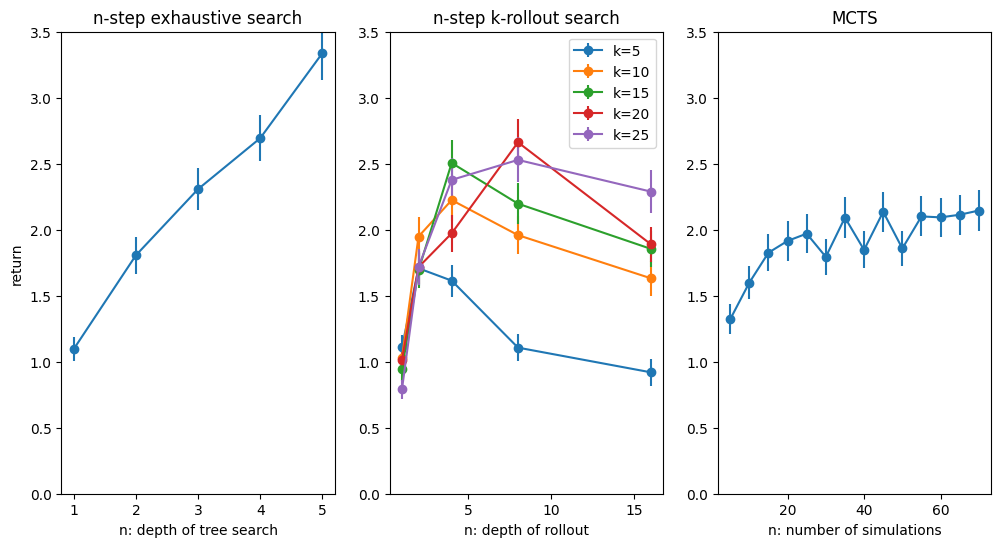

In [100]:
fig, axes = plt.subplots(1, 3, figsize=(12,6))
#axes[0].plot(all_returns.keys(), [np.average(all_returns[x]) for x in all_returns.keys()], ".-")

ns = [1, 2, 3, 4, 5]
axes[0].errorbar(ns, 
                 [np.average(all_returns[x]) for x in ns],
                 yerr = [np.std(all_returns[x])/ np.sqrt(len(all_returns[x])) for x in ns],
                 fmt='-o')
axes[0].set_title("n-step exhaustive search")
axes[0].set_ylabel("return")
axes[0].set_xlabel("n: depth of tree search")

ds = [1, 2, 4, 8, 16]
ns = [5, 10, 15, 20, 25]

for n in ns:
    axes[1].errorbar(ds, 
                     [np.average(rollout_returns[n, d]) for d in ds],
                     yerr = [np.std(rollout_returns[n, d])/ np.sqrt(len(rollout_returns[n, d])) for d in ds],
                     fmt='-o',
                     label="k=%d"%n)
    axes[1].set_title("n-step k-rollout search")    
    axes[1].set_xlabel("n: depth of rollout")
    axes[1].legend()

ns = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]    
axes[2].errorbar(ns, 
                 [np.average(mcts_returns[x]) for x in ns],
                 yerr = [np.std(mcts_returns[x])/ np.sqrt(len(mcts_returns[x])) for x in ns],
                 fmt='-o')
axes[2].set_title("MCTS")
axes[2].set_xlabel("n: number of simulations")
    
for ax in axes: ax.set_ylim(0.,3.5)

In [108]:
axes[2].lines[0].get_ydata()

array([1.321241, 1.598761, 1.825861, 1.915201, 1.970341, 1.7943211,
       2.091961, 1.847181, 2.135961, 1.857961, 2.1008208, 2.0935209,
       2.1135612, 2.1454208], dtype=object)

In [29]:
# k-step n-rollout search

rollout_returns = {}
for n in [5, 10, 15, 20, 25]:
    for d in [1, 2, 4, 8, 16]:
        rollout_returns[n, d] = test_model(n, model, flags, eps_n=500, temp=30., mode=1, d=d, perfect=True)

Testing 1-step 5-rollout planning
Finish 500 episode: avg. return: 1.11 (+-0.09) 
Testing 2-step 5-rollout planning
Finish 500 episode: avg. return: 1.71 (+-0.13) 
Testing 4-step 5-rollout planning
Finish 500 episode: avg. return: 1.61 (+-0.12) 
Testing 8-step 5-rollout planning
Finish 500 episode: avg. return: 1.11 (+-0.10) 
Testing 16-step 5-rollout planning
Finish 500 episode: avg. return: 0.92 (+-0.10) 
Testing 1-step 10-rollout planning
Finish 500 episode: avg. return: 1.03 (+-0.10) 
Testing 2-step 10-rollout planning
Finish 500 episode: avg. return: 1.95 (+-0.15) 
Testing 4-step 10-rollout planning
Finish 500 episode: avg. return: 2.22 (+-0.16) 
Testing 8-step 10-rollout planning
Finish 500 episode: avg. return: 1.96 (+-0.14) 
Testing 16-step 10-rollout planning
Finish 500 episode: avg. return: 1.63 (+-0.13) 
Testing 1-step 15-rollout planning
Finish 500 episode: avg. return: 0.94 (+-0.09) 
Testing 2-step 15-rollout planning
Finish 500 episode: avg. return: 1.69 (+-0.13) 
Testing

In [ ]:
    
    
parser = argparse.ArgumentParser()      
flags = parser.parse_args([])   

env = SokobanWrapper(gym.make("Sokoban-v0"), noop=True)
env = Environment(env)
env.initial()
obs_shape, num_actions = env.gym_env.observation_space.shape, env.gym_env.action_space.n

parser = argparse.ArgumentParser()
flags = parser.parse_args([])   
flags.discounting = 0.97
flags.pb_c_init = 1.25
flags.pb_c_base = 19652
flags.root_dirichlet_alpha = 0.25
flags.root_exploration_fraction = 0.
flags.num_simulations = 20
flags.temp = 0.5
flags.model_type_nn = 0
flags.device = torch.device("cuda")

eps_n = 100
eps_n_cur = 0

model = Model(flags, obs_shape, num_actions=num_actions).to(device=flags.device)
model.train(False)
checkpoint = torch.load("../models/model_1.tar")
model.load_state_dict(checkpoint["model_state_dict"])  

obs = env.initial()
returns = []
mcts = MCTS(flags, num_actions)
while(len(returns) <= eps_n):
    cur_returns = obs['episode_return']    
    obs = {k:v.to(flags.device) for k, v in obs.items()}
    root, extra_info = mcts.run(model, obs, add_exploration_noise=True)    
    new_action = select_action(root, flags.temp)    
    #plt.imshow(torch.swapaxes(torch.swapaxes(obs['frame'][0,0].to(
    #flags.device).clone().cpu(),0,2),0,1), interpolation='nearest')
    #plt.show()
    #print("action selected", new_action)
    #print("===========================================")
    obs = env.step(torch.tensor([new_action]))
    if torch.any(obs['done']):
        returns.extend(cur_returns[obs['done']].numpy())
    if eps_n_cur <= len(returns) and len(returns) > 0: 
        eps_n_cur = len(returns) + 10
print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
            np.average(returns), np.std(returns) / np.sqrt(len(returns))))

In [ ]:
# Debugging planning algorithm
bsz = 1
env = gym.vector.SyncVectorEnv([lambda: SokobanWrapper(gym.make("Sokoban-v0"), noop=True)] * bsz)
env = Vec_Environment(env, bsz)
obs = env.initial()
state = obs['frame'][0].to(flags.device).clone()
action = torch.zeros(bsz).long().to(flags.device)
encoded = None

In [ ]:
action = torch.Tensor([4]).long().to(flags.device)
obs = env.step(action)
state = obs['frame'][0].to(flags.device).clone()

In [ ]:
plt.imshow(torch.swapaxes(torch.swapaxes(state[0].cpu(),0,2),0,1), interpolation='nearest')
plt.show()

In [ ]:
from matplotlib import pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
device = flags.device

for _ in range(1):
    plt.imshow(torch.swapaxes(torch.swapaxes(state[0].cpu(),0,2),0,1), interpolation='nearest')
    plt.show()
    ret = np.zeros((5, 5, 5))
    for i in range(5):
        for j in range(5):
            for k in range(5):
                test_action_seq = [i,j,k]
                test_action_seq = torch.Tensor(test_action_seq).unsqueeze(-1).long().to(device)  
                old_new_actions = torch.concat([action.unsqueeze(0), test_action_seq], dim=0)
                rs, vs, logits, encodeds = model(state, old_new_actions)
                ret[i, j, k] = rs[0] + rs[1] * 0.97 + rs[2] * (0.97**2) + vs[-1] * (0.97**3)
    print(np.max(ret), (np.max(ret) == ret).nonzero())    
    new_action = torch.Tensor((np.max(ret) == ret).nonzero()[0]).long().to(flags.device)
    #obs = env.step(new_action)
    #state = obs['frame'][0].to(flags.device).clone()
    #action = new_action            

In [ ]:
action, prob, q_ret = n_step_greedy_model(state, action, model, 3, encoded=None, temp=10.)
print("action: ", action)
print("prob: ", prob)
print("q_ret: ", q_ret)

In [ ]:
test_action_seq = [2,3,1]
test_action_seq = torch.Tensor(test_action_seq).unsqueeze(-1).long().to(device)  
old_new_actions = torch.concat([action.unsqueeze(0), test_action_seq], dim=0)
rs, vs, logits, encodeds = model(state, old_new_actions)
ret[i, j, k] = rs[0] + rs[1] * 0.97 + rs[2] * (0.97**2) + vs[-1] * (0.97**3)
print("rs", rs)
print("vs", vs)
print("logits", logits)
print("ret", ret[i,j,k])

In [ ]:
temp = 10.

bsz = state.shape[0]
device = state.device 
num_actions = model.num_actions    
model.train(False)

q_ret = torch.zeros(bsz, num_actions).to(device)        
rs_act = torch.zeros(bsz, num_actions).to(device)        
vs_act = torch.zeros(bsz, num_actions).to(device)        

for act in range(num_actions):        
    new_action = torch.Tensor(np.full(bsz, act)).long().to(device)    
    old_new_actions = torch.concat([action.unsqueeze(0), new_action.unsqueeze(0)], dim=0)
    rs, vs, logits, encodeds = model(state, old_new_actions)
    ret = rs[0] + flags.discounting * vs[1]
    rs_act[:, act] = rs[0]
    vs_act[:, act] = vs[1]
    q_ret[:, act] = ret

prob = F.softmax(temp*q_ret, dim=1)
action = torch.multinomial(prob, num_samples=1)[:, 0]

print("rs_act", rs_act)
print("vs_act", vs_act)
print("q_ret", q_ret)
print("prob", prob)

In [ ]:
device = flags.device
net_state = env.clone_state()

bsz = 1
temp = 10.
q_ret = torch.zeros(bsz, num_actions).to(device)      
rs_act = torch.zeros(bsz, num_actions).to(device)        
vs_act = torch.zeros(bsz, num_actions).to(device)   

net = net.to(device)

for act in range(num_actions):
    obs = env.step(torch.Tensor(np.full(bsz, act)).long())      
    obs = {k:v.to(device) for k, v in obs.items()}   
    ret = obs['reward'] + flags.discounting * net(obs)[0]['baseline'] * (~obs['done']).float()
    rs_act[:, act] = obs['reward']
    vs_act[:, act] = net(obs)[0]['baseline']
    q_ret[:, act] = ret
    env.restore_state(net_state)

prob = F.softmax(temp*q_ret, dim=1)
action = torch.multinomial(prob, num_samples=1)[:, 0]

print("rs_act", rs_act)
print("vs_act", vs_act)
print("q_ret", q_ret)
print("prob", prob)

plt.imshow(torch.swapaxes(torch.swapaxes(state[0].cpu(),0,2),0,1), interpolation='nearest')
plt.show()

In [ ]:
batch = get_batch_m(flags, buffers)
print(torch.max(batch["reward"]), (torch.max(batch["reward"]) == batch["reward"]).nonzero())
print(batch["done"].nonzero())

In [ ]:
# DEBUG LOSS

#batch = get_batch_m(flags, buffers)

model.train(False)

rs, vs, logits, _ = model(batch['frame'][0], batch['action'])
logits = logits[:-1]

target_rewards = batch['reward'][1:]
target_logits = batch['policy_logits'][1:]

target_vs = []
target_v = model(batch['frame'][-1], batch['action'][[-1]])[1][0]    

for t in range(vs.shape[0]-1, 0, -1):
    new_target_v = batch['reward'][t] + flags.discounting * (target_v * (~batch['done'][t]).float() +
                       vs[t-1] * (batch['truncated_done'][t]).float())
    target_vs.append(new_target_v.unsqueeze(0))
    target_v = new_target_v
target_vs.reverse()
target_vs = torch.concat(target_vs, dim=0)

# if done on step j, r_{j}, v_{j-1}, a_{j-1} has the last valid loss 
# rs is stored in the form of r_{t+1}, ..., r_{t+k}
# vs is stored in the form of v_{t}, ..., v_{t+k-1}
# logits is stored in the form of a{t}, ..., a_{t+k-1}

done_masks = []
done = torch.zeros(vs.shape[1]).bool().to(batch['done'].device)
for t in range(vs.shape[0]):
    done = torch.logical_or(done, batch['done'][t])
    done_masks.append(done.unsqueeze(0))

done_masks = torch.concat(done_masks[:-1], dim=0)

# compute final loss
huberloss = torch.nn.HuberLoss(reduction='none', delta=1.0)    
#rs_loss = torch.sum(huberloss(rs, target_rewards) * (~done_masks).float())
rs_loss = torch.sum(((rs - target_rewards) ** 2) * (~done_masks).float())
#vs_loss = torch.sum(huberloss(vs[:-1], target_vs) * (~done_masks).float())
vs_loss = torch.sum(((vs[:-1] - target_vs) ** 2) * (~done_masks).float())
logits_loss = compute_cross_entropy_loss(logits, target_logits, done_masks)

# debug
ind = 10

target_vs = []
target_v = vs[-1]
for t in range(vs.shape[0]-1, 0, -1):        
    new_target_v = batch['reward'][t] + flags.discounting * (target_v * (~batch['done'][t]).float() +
                       vs[t-1] * (batch['truncated_done'][t]).float())
    print(t, 
          "reward %2f" % batch['reward'][t,ind].item(), 
          "bootstrap %2f" % (target_v * (~batch['done'][t]).float())[ind].item(), 
          "truncated %2f" % (vs[t-1] * (batch['truncated_done'][t]).float())[ind].item(),
          "vs[t-1] %2f" % vs[t-1][ind].item(),
          "new_targ %2f" % new_target_v[ind].item())
    target_vs.append(new_target_v.unsqueeze(0))    
    target_v = new_target_v
target_vs.reverse()
target_vs = torch.concat(target_vs, dim=0)   
print("done", batch["done"][:, ind])
print("done_masks", done_masks[:, ind])
print("vs: ", vs[:, ind])
print("target_vs: ", target_vs[:, ind])
print("reward: ", rs[:, ind])
print("target_reward: ", target_rewards[:, ind])
print("logits: ", logits[:, ind])
print("target_logits: ", target_logits[:, ind])

In [ ]:
# a mixture of perfect model and learned model


def n_step_greedy_(env, obs, net, model, n, temp=10.):    
    if isinstance(env, Vec_Environment):
        num_actions = env.gym_env.action_space[0].n
        bsz = len(env.gym_env.envs)
    else:
        num_actions = env.gym_env.action_space.n
        bsz = 1

    q_ret = torch.zeros(bsz, num_actions).to(device)      
    state = env.clone_state()
    
    _, _, _, encodeds = model(obs['frame'][0], obs['last_action'], one_hot=False)
    encoded = encodeds[-1]
    
    for act in range(num_actions):
        a = torch.Tensor(np.full(bsz, act)).long()
        obs = env.step(a)      
        obs = {k:v.to(device) for k, v in obs.items()}          
        
        if n > 1:
            action, prob, sub_q_ret = n_step_greedy(env, net, model, n-1)
            ret = obs['reward'] + flags.discounting * torch.max(sub_q_ret, dim=1)[0] * (~obs['done']).float()
        else:
            
            baseline1 = net(obs)[0]['baseline']
            _, baselines2, _, _ = model(obs['frame'][0], obs['last_action'], one_hot=False)
            baseline2 = baselines2[-1]
            rs3, baselines3, _, _ = model.forward_encoded(encoded, a.to(device).unsqueeze(0), one_hot=False)
            baseline3 = baselines3[-1]
            
            #print("baseline_1", baseline1)
            #print("baseline_2", baseline2)
            #print("baseline_3", baseline3)
            ret = obs['reward'] + flags.discounting * net(obs)[0]['baseline'] * (~obs['done']).float()
            #ret = obs['reward'] + flags.discounting * baseline2 * (~obs['done']).float()
            #ret = rs3[0] + flags.discounting * baseline3 * (~obs['done']).float()

        q_ret[:, act] = ret
        env.restore_state(state)
    
    prob = F.softmax(temp*q_ret, dim=1)
    action = torch.multinomial(prob, num_samples=1)[:, 0]
    
    return action, prob, q_ret  

# alt. version of computing loss by treading terminal state as absorbing state (as in MuZero)

def compute_loss_m(model, batch):

    rs, vs, logits, _ = model(batch['frame'][0], batch['action'])
    logits = logits[:-1]

    target_logits = batch['policy_logits'][1:].clone()
    target_rewards = batch['reward'][1:].clone()

    done_masks = []
    done = torch.zeros(vs.shape[1]).bool().to(batch['done'].device)

    c_logits = target_logits[0]
    c_state = batch['frame'][0]
    for t in range(vs.shape[0]-1):
        if t > 0: done = torch.logical_or(done, batch['done'][t])
        c_logits = torch.where(done.unsqueeze(-1), c_logits, target_logits[t])
        target_logits[t] = c_logits
        c_state = torch.where(done.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1), c_state, batch['frame'][t])  
        done_masks.append(done.unsqueeze(0))
    done_masks = torch.concat(done_masks, dim=0)
    done = torch.logical_or(done, batch['done'][-1])
    c_state = torch.where(done.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1), c_state, batch['frame'][-1])
    target_rewards = target_rewards * (~done_masks).float()

    target_vs = []
    target_v = model(c_state, batch['action'][[-1]])[1][0].detach()
    
    for t in range(vs.shape[0]-1, 0, -1):
        new_target_v = batch['reward'][t] + flags.discounting * target_v
        target_vs.append(new_target_v.unsqueeze(0))
        target_v = new_target_v
    target_vs.reverse()
    target_vs = torch.concat(target_vs, dim=0)
    
    # compute final loss
    huberloss = torch.nn.HuberLoss(reduction='none', delta=1.0)    
    rs_loss = torch.sum(huberloss(rs, target_rewards.detach()))
    #rs_loss = torch.sum(((rs - target_rewards) ** 2) * (~r_logit_done_masks).float())
    vs_loss = torch.sum(huberloss(vs[:-1], target_vs.detach()))
    #vs_loss = torch.sum(((vs[:-1] - target_vs) ** 2) * (~v_done_masks).float())
    logits_loss = compute_cross_entropy_loss(logits, target_logits.detach(), None)
    
    return rs_loss, vs_loss, logits_loss